<a href="https://colab.research.google.com/github/Rakhayeva/Data-Science-Projects-in-English/blob/main/hr_decisions_business_oprimization_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Description

The company "Work with Care" aims to optimize personnel management, minimize employee churn, and avoid financial losses using data and machine learning.

**Project Goal**

Task 1: Build a model to predict the level of employee satisfaction based on provided characteristics. **Success criterion**: SMAPE ≤15 on the test set.

Task 2: Build a model to predict the probability of employee churn (resignation). **Success criterion**: ROC-AUC ≥0.91 on the test set.

**Research Methodology**

**Task 1: Satisfaction Level Prediction**

Step 1: [Data Loading](#Loading):

- Check loaded data for errors.

- Ensure data is correctly split into training and test sets.

Step 2: [Data Preprocessing](#Preprocessing):

- Analyze missing values, duplicates, and outliers.|
- Implement the pipeline: encoding, scaling, removing outliers, imputing missing values.

Step 3: [Exploratory Data Analysis (EDA)](#EDA):

- Plot distributions for each feature.
- Evaluate correlations between features and the target variable.
- Check data for multicollinearity.

Step 4: [Data Preparation](#Preparation):

- Decide on encoding for categorical features (dept, level).
- Develop a pipeline to automate data processing.

- Apply two encoding approaches (e.g., OneHotEncoder and OrdinalEncoder).

Step 5: [Model Training](#Training):

- Implement two models: Linear Regression and Decision Tree.
- Tune hyperparameters using tools like GridSearchCV.
- Add a function to calculate SMAPE.
- Compare models and select the best one.

Step 6: [Feature Analysis](#Feature)

- Compare model performance on the test set.
- Analyze feature importance using SHAP values to identify satisfaction drivers.
- Justify the selection of the final model.

**Task 2: Churn Prediction**

Step 1: [Data Loading](#Loading2)
- Check target data for errors.
- Check data consistency.

Step 2: [Data Preprocessing](#Preprocessing2):
- Apply the pipeline created in Task 1, adapted for the new objectives.

Step 3: [Exploratory Data Analysis (EDA)](#Exploratory):
   - Study features related to churn:
   - Determine average salaries of employees who left.
   - Analyze departments most susceptible to churn.
   - Compare satisfaction level distributions between staying and leaving employees.
   - Evaluate correlations between features and the target variable.
   - Check data for multicollinearity.
   
Step 4: [Feature Engineering](Engineering2):
- Use predictions from the Task 1 model to enrich the feature set.

Step 5: [Data Preparation](#Preparation2):
- Implement the pipeline: encoding, scaling, removing outliers, imputing missing values.
- Apply two encoding approaches (e.g., OneHotEncoder and OrdinalEncoder).

Step 6: [Model Training](#Training2):
- Train three models: Logistic Regression, RandomForestRegressor, Gradient Boosting.
- Tune hyperparameters for at least two models.
- Success Criterion: **ROC-AUC 0.91** on the test set.
- Select the best model.

Step 7: [Feature Analysis](#Feature2):
- Formulate conclusions regarding model quality.
- Conduct SHAP analysis to identify the primary triggers for employee resignation.

**General Conclusion**
- Presentation of results for each task.
- Formulation of business recommendations for the HR department

**Evaluation Metrics:**
- **SMAPE** (Task 1)
- **ROC-AUC** (Task 2)

## Data Description

The dataset includes the following features:

- `id`: Unique employee identifier.
- `dept`: Department where the employee works.
- `level`: Position level.
- `workload`: Employee workload level.
- `employment_years`: Duration of employment in the company (in years).
- `last_year_promo`: Indicates if there was a promotion in the last year.
- `last_year_violations`: Indicates if the employee violated the employment contract in the last year.
- `supervisor_evaluation`: Quality assessment of the employee's work given by the supervisor.
- `salary`: Monthly employee salary.
- `job_satisfaction_rate`: Employee's satisfaction level with working at the company (Target Variable).

## Task 1: Satisfaction Level Prediction

### Importing libraries and modules:

In [1]:
!pip install phik -q

In [2]:
import warnings
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from phik import phik_matrix
from scipy.stats import chi2_contingency
from sklearn.dummy import DummyRegressor
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Constants:

In [3]:
RANDOM_STATE = 42

### Functions

In [4]:
def detailed_df_analysis(df):
    """
    Create a function to obtain extended preliminary information about the data table.
    """
    display(df.head())
    print('')
    display(df.info())
    print('')
    display(df.describe().T)
    print('')
    # Missing values
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    print("Missing values:")
    print(pd.DataFrame({'count': missing_values, 'percentage': missing_percent}), "\n")

    # Number of row duplicates
    duplicates = df.duplicated().sum()
    print(f"Number of duplicates: {duplicates}\n")

    # Information on categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print("Information about categorical features:")
        for col in categorical_cols:
            unique_count = df[col].nunique()
            unique_values = df[col].unique()
            print(f"{col} => {unique_count} unique values")
            for value in unique_values:
                print(f"  - {value}")
            print()
    else:
        print("No categorical features present.\n")

In [5]:
def numeric_plot(df):
    """
    Plots histograms or bar charts and boxplots for numeric columns,
    depending on their type (float or int), excluding 'id'.
    """
    # Set plot size
    plt.rcParams["figure.figsize"] = (18, 15)

    # Select numeric columns, excluding 'id' if present
    numeric_cols = df.select_dtypes(include=['number']).columns
    numeric_cols = numeric_cols.drop('id', errors='ignore')

    # If no numeric columns, print message and exit function
    if len(numeric_cols) == 0:
        print("No numeric columns found.")
        return

    # Number of rows and columns in the plot grid
    num_cols = 2  # Two plots (histogram/bar and boxplot) per row
    num_rows = len(numeric_cols)

    # Create figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()  # Simplify access to axes

    # Plotting
    for i, col in enumerate(numeric_cols):
        unique_values = df[col].nunique()

        # Float data — plot histogram
        if df[col].dtype == 'float':
            sns.histplot(df[col], bins=15, kde=False, color="skyblue", ax=axes[2 * i])
            axes[2 * i].set_title(f'Histogram for {col}')
            axes[2 * i].set_xlabel(col)
            axes[2 * i].set_ylabel('Frequency')

        # Integer data — plot either bar chart or histogram
        elif df[col].dtype == 'int':
            if unique_values > 20:
                sns.histplot(df[col], bins=15, kde=False, color="skyblue", ax=axes[2 * i])
                axes[2 * i].set_title(f'Histogram for {col}')
            else:
                sns.countplot(x=df[col], color="skyblue", ax=axes[2 * i])
                axes[2 * i].set_title(f'Bar chart for {col}')
            axes[2 * i].set_xlabel(col)
            axes[2 * i].set_ylabel('Count')

        # Boxplot
        sns.boxplot(x=df[col], color="skyblue", ax=axes[2 * i + 1])
        axes[2 * i + 1].set_title(f'Boxplot for {col}')
        axes[2 * i + 1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

def categorical_target_plot(data, target):
    """
    Function plots charts for all categorical features in the dataset.
    Args:
        data (pandas.DataFrame): Dataset.
        target (str): Target feature.
    Returns:
        None
    """
    # Set plot size
    plt.rcParams["figure.figsize"] = (18, 6)

    # Select categorical columns
    categorical_columns = data.select_dtypes(exclude='number').columns.tolist()

    # Plotting charts
    for i, feature in enumerate(categorical_columns):
        plt.subplot(1, len(categorical_columns), i + 1)  # Number of plots in a row = number of categorical features
        sns.boxplot(data=data, x=feature, y=target)
        plt.title(feature)
        plt.xlabel('')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def plot_pie_and_bar_charts(df):
    """
    Plots pie charts and bar charts for each categorical feature in the DataFrame.
    """
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    num_charts = len(categorical_cols)

    # Create figure and axes. Fixed figure size for better control
    fig, axes = plt.subplots(num_charts, 2, figsize=(12, 5 * num_charts)) # Increase height proportionally to the number of charts

    # Reshape axes into a 2D array, even if there is only one chart
    if num_charts == 1:
        axes = axes.reshape(1, 2)

    for i, col in enumerate(categorical_cols):
        value_counts = df[col].value_counts()

        # Pie chart
        axes[i, 0].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10}) # Increased text size in pie chart
        axes[i, 0].set_title(f'Pie chart for {col}', fontsize=12) # Increased title size

        # Bar chart
        axes[i, 1].bar(value_counts.index, value_counts.values, color='skyblue')
        axes[i, 1].set_title(f'Bar chart for {col}', fontsize=12) # Increased title size
        axes[i, 1].set_ylabel('Count', fontsize=10) # Increased axis label size
        axes[i, 1].set_xlabel(col, fontsize=10) # Increased axis label size
        axes[i, 1].tick_params(axis='x', rotation=45, labelsize=10) # Increased label size and rotated them
        axes[i, 1].tick_params(axis='y', labelsize=10) # Increased label size

    plt.tight_layout(pad=2.0) # Automatic padding adjustment, pad - distance from borders
    plt.show()

### <a name='Loading'></a> Data Loading

In [6]:
# Data loading
job_X_train = pd.read_csv('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/train_job_satisfaction_rate.csv')
job_X_test = pd.read_csv('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/test_features.csv')
job_y_test = pd.read_csv('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/test_target_job_satisfaction_rate.csv')

In [7]:
detailed_df_analysis(job_X_train)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0



Missing values:
                       count  percentage
id                         0        0.00
dept                       6        0.15
level                      4        0.10
workload                   0        0.00
employment_years           0        0.00
last_year_promo            0        0.00
last_year_violations       0        0.00
supervisor_evaluation      0        0.00
salary                     0        0.00
job_satisfaction_rate      0        0.00 

Number of duplicates: 0

Information about categorical features:
dept => 5 unique values
  - sales
  - hr
  - technology
  - purchasing
  - marketing
  - nan

level => 3 unique values
  - junior
  - middle
  - sinior
  - nan

workload => 3 unique values
  - medium
  - high
  - low

last_year_promo => 2 unique values
  - no
  - yes

last_year_violations => 2 unique values
  - no
  - yes



- There are missing values in the dept and level columns.
- Spelling error found in sinior within the level parameter.
- No explicit duplicates found.
- Preliminarily, no anomalous values detected, but there are outliers in the `employment_years` and `salary parameters`, as the maximum values differ significantly from the third quartile. We will investigate them during the exploratory phase.
- Data types are in order.

In [8]:
detailed_df_analysis(job_X_test)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0



Missing values:
                       count  percentage
id                         0        0.00
dept                       2        0.10
level                      1        0.05
workload                   0        0.00
employment_years           0        0.00
last_year_promo            0        0.00
last_year_violations       0        0.00
supervisor_evaluation      0        0.00
salary                     0        0.00 

Number of duplicates: 0

Information about categorical features:
dept => 6 unique values
  - marketing
  - hr
  - sales
  - purchasing
  - technology
  - nan
  -  

level => 3 unique values
  - junior
  - middle
  - sinior
  - nan

workload => 4 unique values
  - medium
  - low
  - high
  -  

last_year_promo => 2 unique values
  - no
  - yes

last_year_violations => 2 unique values
  - no
  - yes



- There are missing values in the `dept`, `level`, and `workload` columns in the form of NaN and " " (whitespace) in the last two parameters.
- Spelling error found in sinior within the level parameter.
- No explicit duplicates found.
- Preliminarily, no anomalous values detected, but there are outliers in the `employment_years` and `salary parameters`, as the maximum values differ significantly from the third quartile. We will investigate them during the exploratory phase.
- Data types are in order.

In [9]:
detailed_df_analysis(job_y_test)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21350,253851.326129,100298.00,339052.00,550793.00,765763.75,999029.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0



Missing values:
                       count  percentage
id                         0         0.0
job_satisfaction_rate      0         0.0 

Number of duplicates: 0

No categorical features present.



- No missing values detected.
- No explicit duplicates detected.
- Preliminarily, no anomalous values detected.
- Data types are in order.

### <a name='Preprocessing'></a> Data Preprocessing


In [10]:
# Correct a spelling error
job_X_train['level'].replace({'sinior': 'senior'}, inplace=True)

/tmp/ipython-input-2488481562.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  job_X_train['level'].replace({'sinior': 'senior'}, inplace=True)


In [11]:
# Pipeline for replacing missing values
imputer_pipe = Pipeline(
    [
        (
            'SimpleImputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
)

In [12]:
# Display all rows with missing values in the dataset
job_X_train[job_X_train['dept'].isnull() | job_X_train['level'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [13]:
# Handle missing values using a pipeline
nan_cols = ['dept', 'level']
job_X_train[nan_cols] = imputer_pipe.fit_transform(job_X_train[nan_cols])

# Verification
display(job_X_train[job_X_train['dept'].isnull() | job_X_train['level'].isnull()])
print(f'Number of missing values after replacement: \n {job_X_train.isna().sum()}')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate


Number of missing values after replacement: 
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


For `job_X_train`:

- Corrected the spelling error sinior -> senior in the level column.
- Replaced NaN missing values in the dept and level parameters using a pipeline (SimpleImputer).

### <a name='EDA'></a> Exploratory Data Analysis (EDA)

Plotting distributions for each feature:

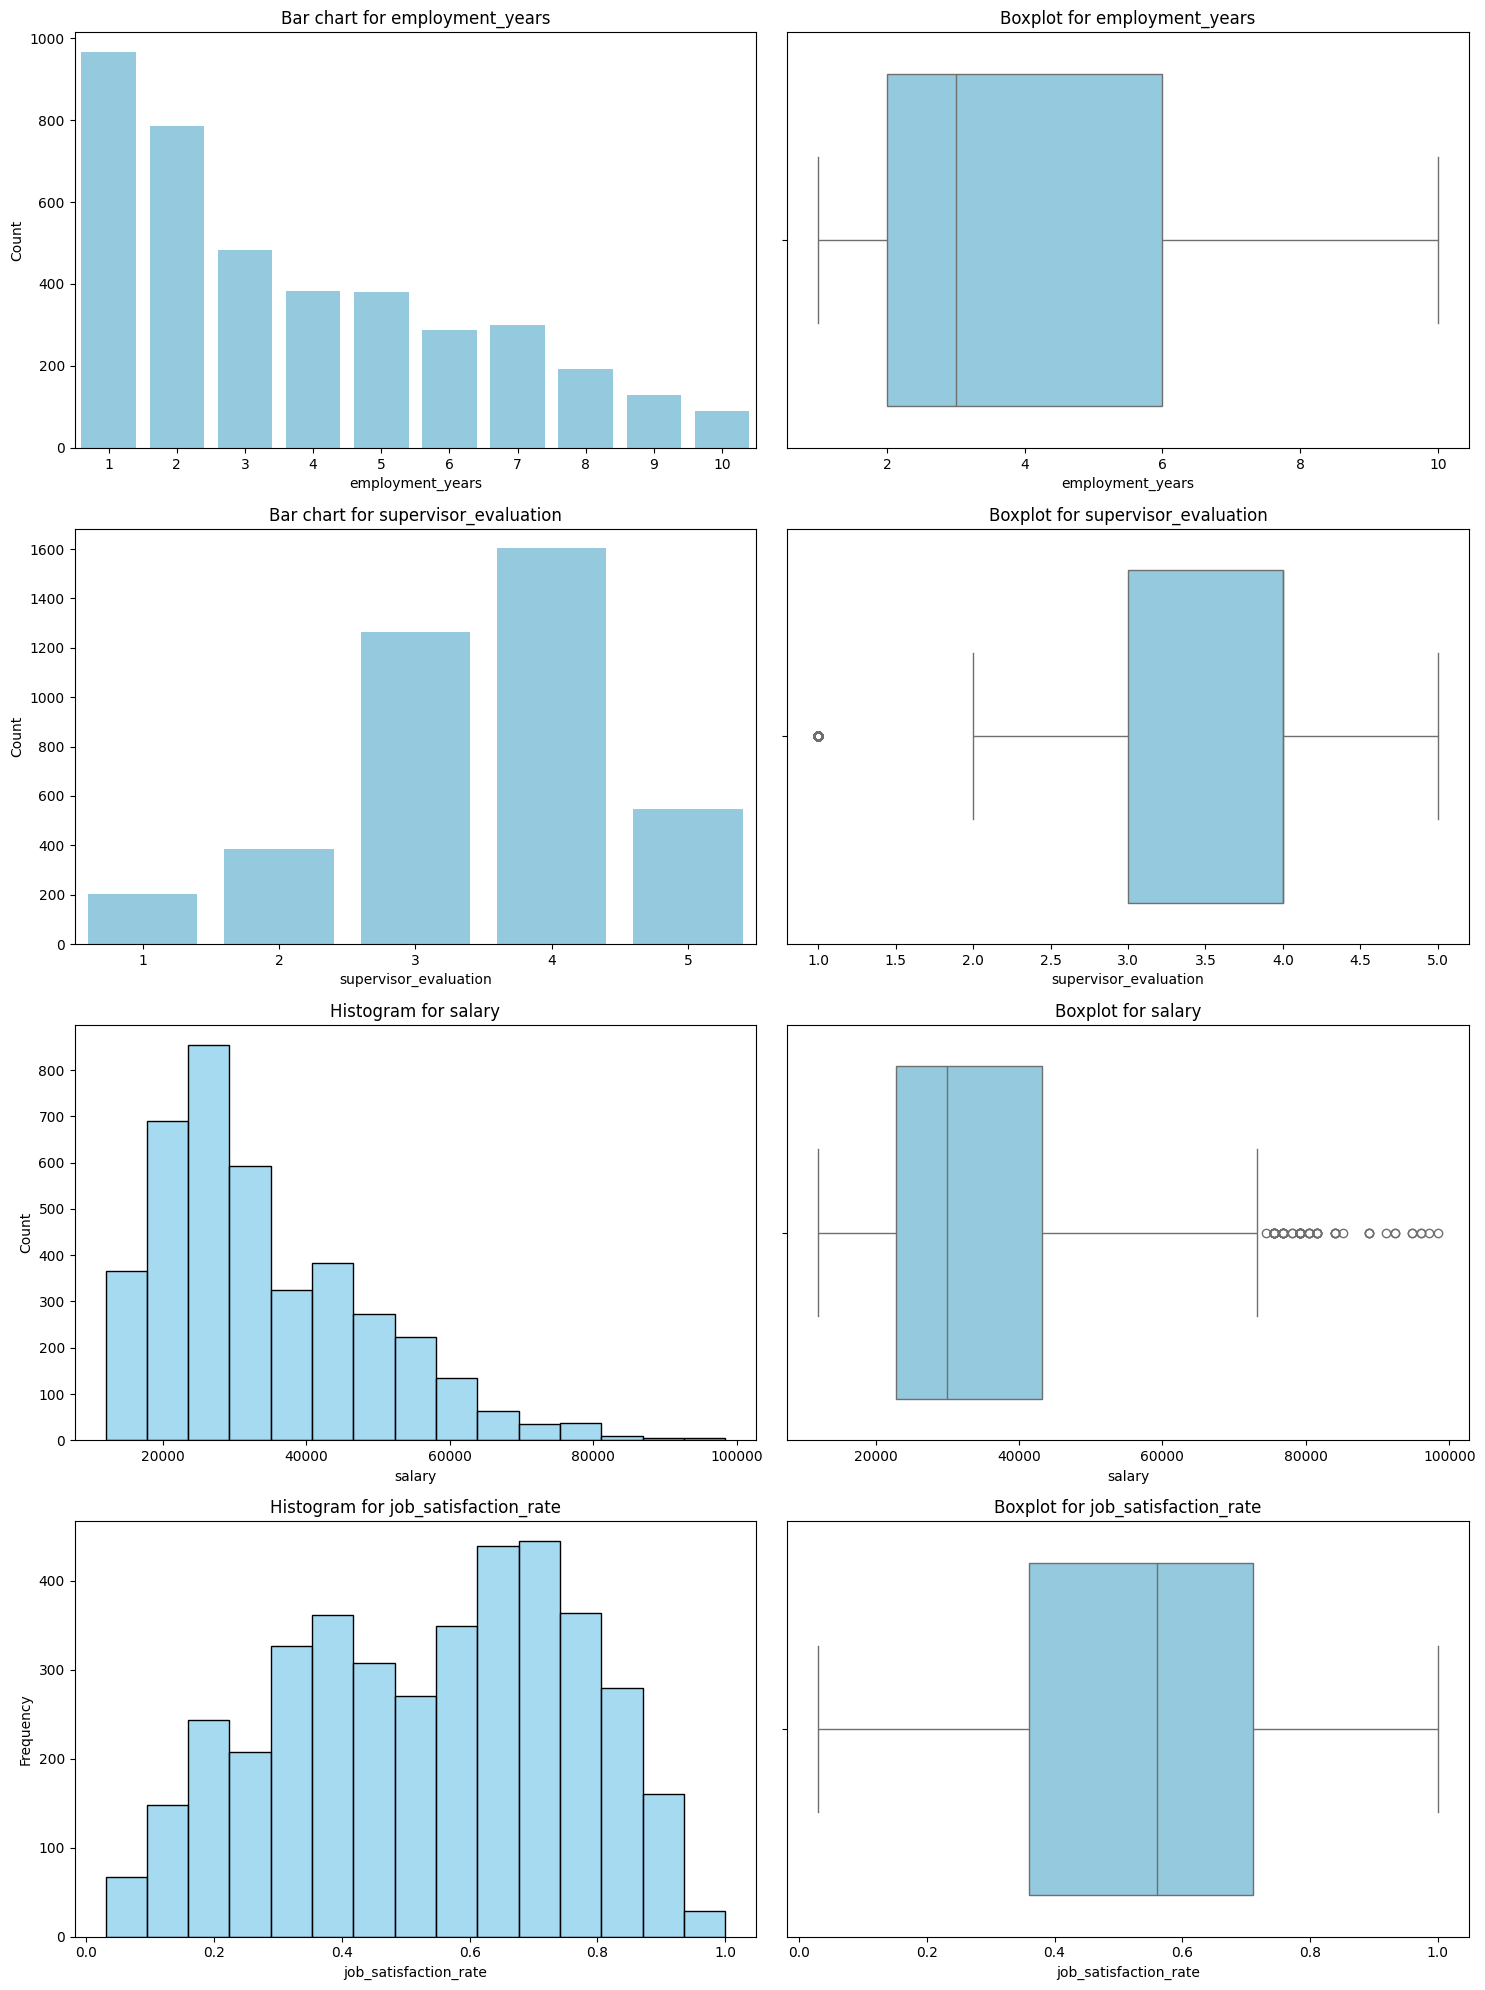

In [14]:
numeric_plot(job_X_train)

- The `employment_years` feature is distributed irregularly. There is a right skew. The company has almost twice as many employees who have worked there for less than 3 years; there are significantly fewer experienced employees. This should be taken into account when selecting parameters for the model.
- The most frequent employee performance evaluation given by the supervisor is 4.
- The `salary` feature has a right-skewed distribution. This indicates a small number of employees with high salaries, while the median salary in the company is 30,000. Outliers are visible on the graph; however, we will not remove them due to their small quantity and the representativeness of high employee salaries. The spread is quite large, so scaling should be applied.
- The `job_satisfaction_rate` feature has a non-normal distribution, slightly left-skewed with three peaks.

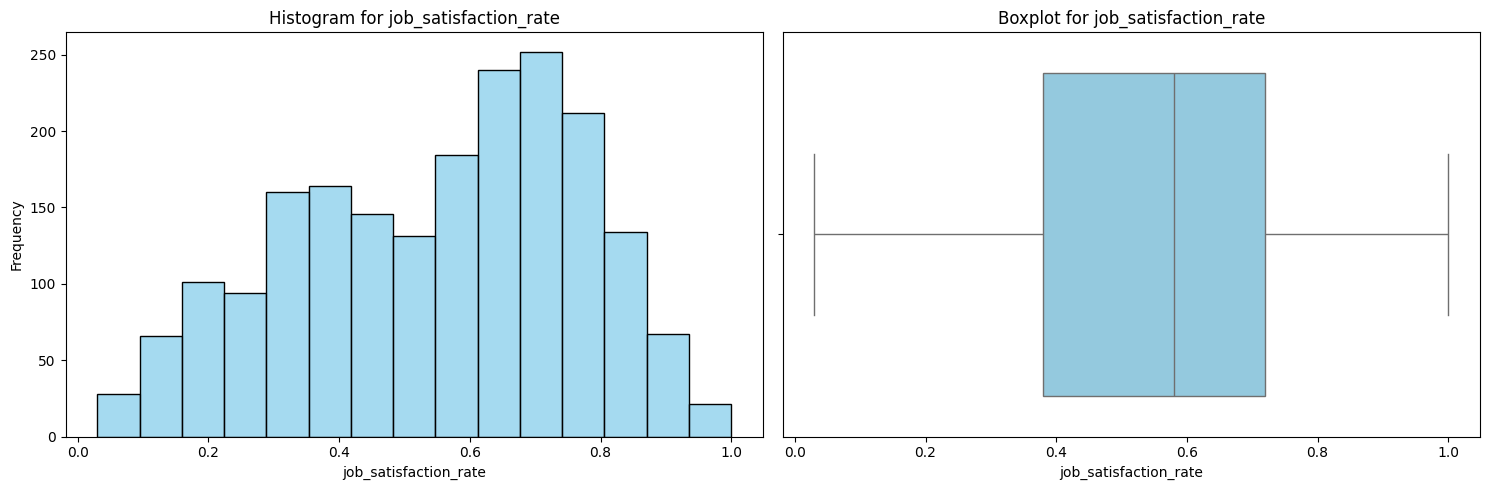

In [15]:
numeric_plot(job_y_test)

The target feature distribution in the test set is identical to the training set.

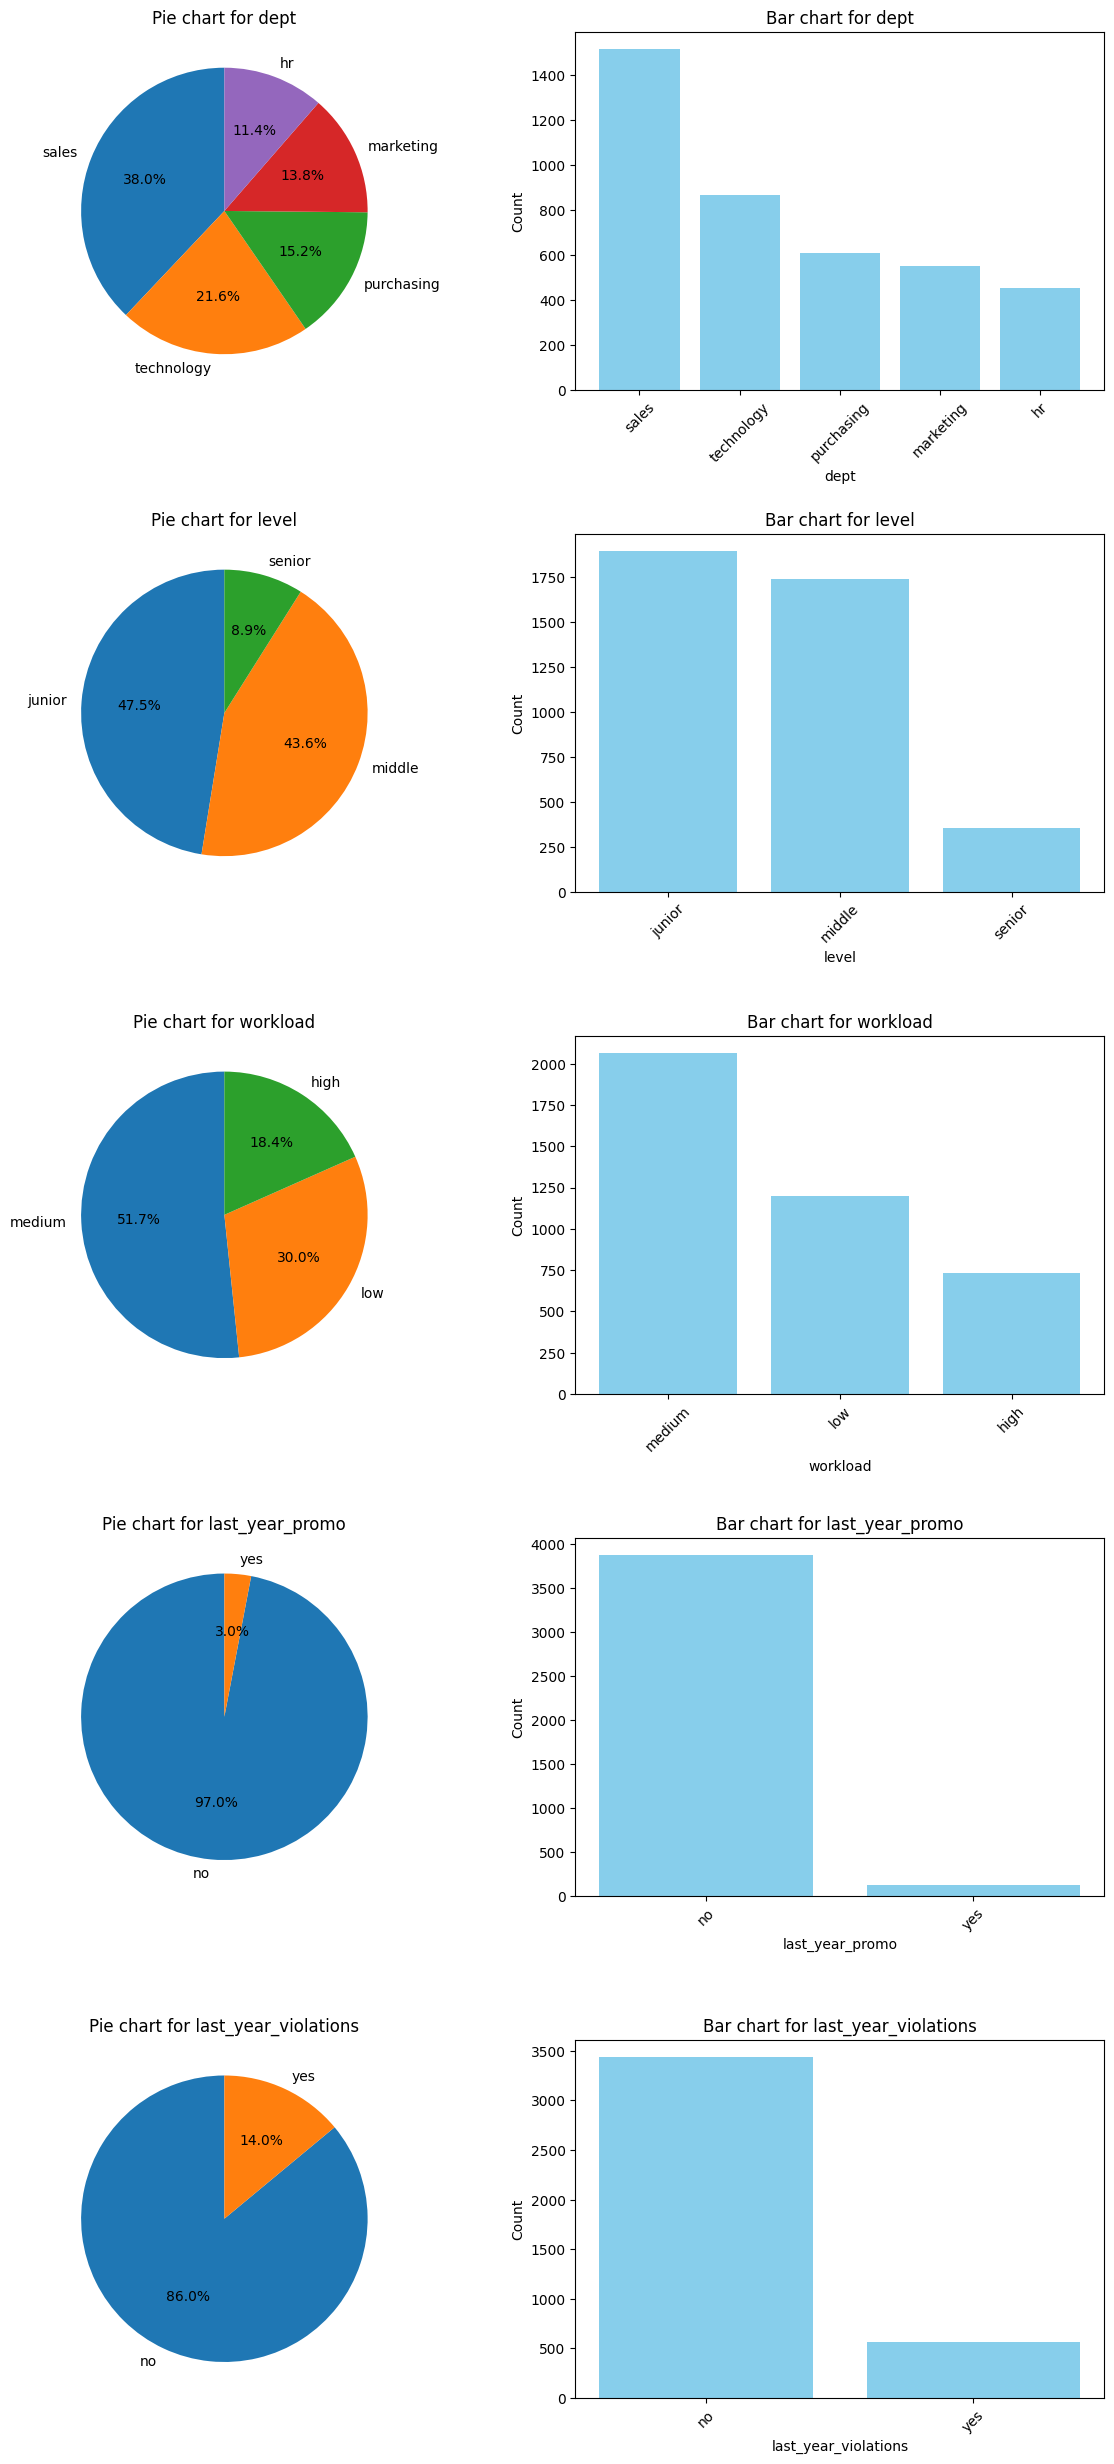

In [16]:
plot_pie_and_bar_charts(job_X_train)

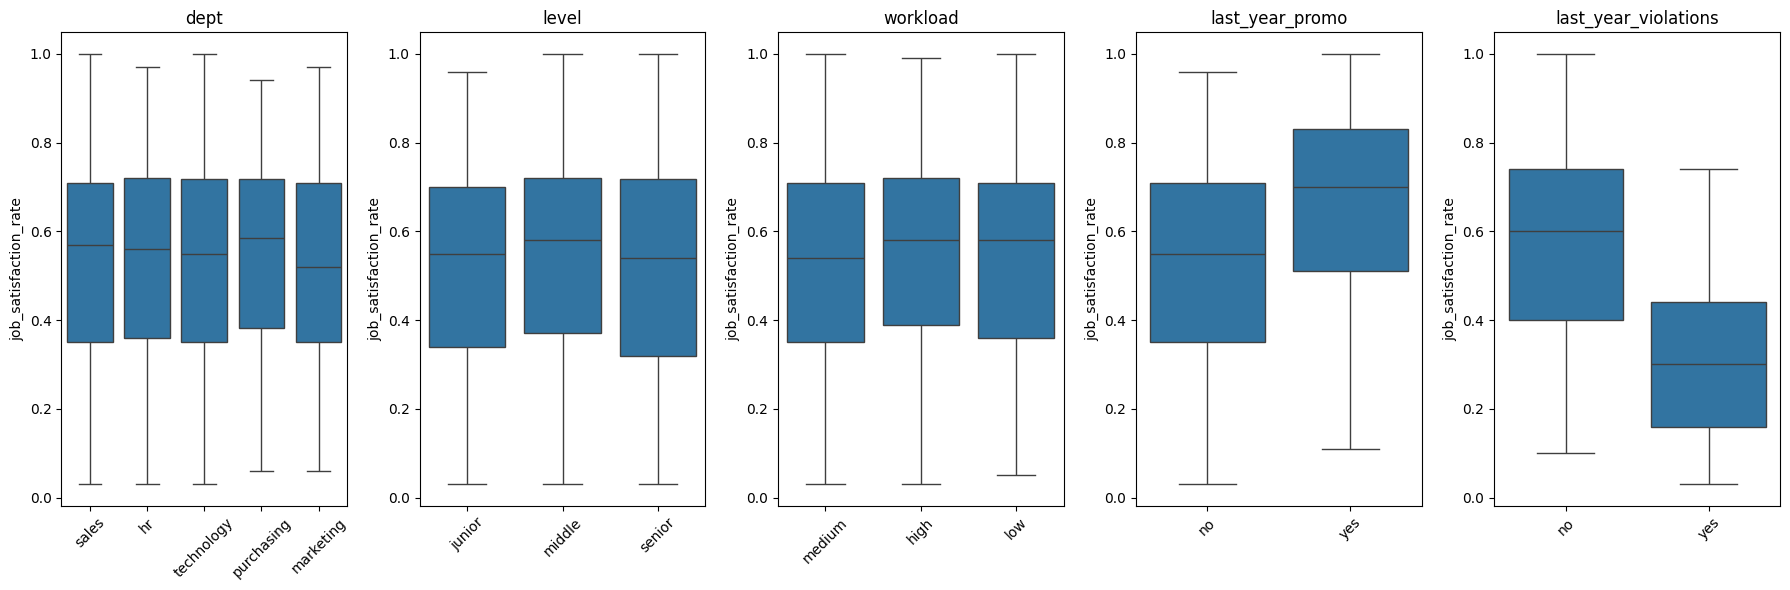

In [17]:
categorical_target_plot(job_X_train, 'job_satisfaction_rate')

- The largest number of employees (38%) work in the "Sales" department; however, the highest job satisfaction is observed among employees in the "Purchasing" department.
- 47.5% of employees hold junior positions, and about 43.6% are middle. Employees at the middle level are the most satisfied with their jobs.
- The majority of employees (51.6%) have a medium workload.
- A clear factor for satisfaction is a promotion in the last year or the absence of violation notices.

For most categorical features, we will use OneHotEncoder, and for the `level` and `workload` features, we will test OrdinalEncoder.

#### Evaluation of correlations between features and the target variable

We will check the correlation analysis between numerical features using the Spearman method:

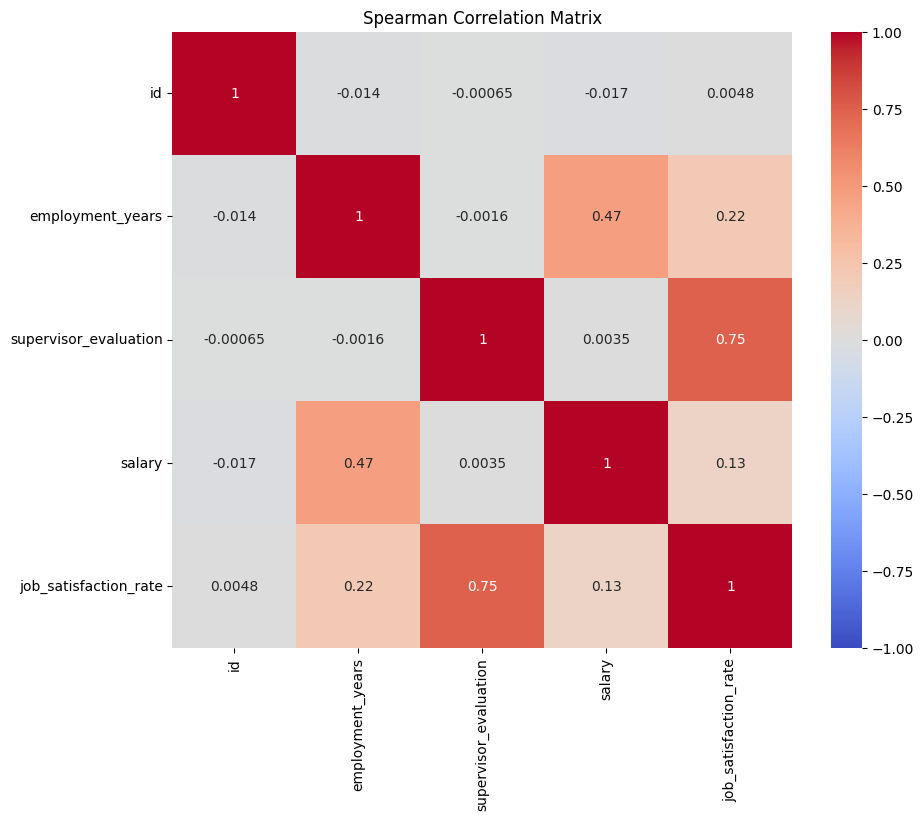

In [18]:
# Select all numeric columns
numeric_cols = job_X_train.select_dtypes(include=['number']).columns

# Calculate Spearman correlation matrix
correlation_matrix_spearman = job_X_train[numeric_cols].corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm', vmin=-1, vmax=1) # Added vmin and vmax for correct display
plt.title('Spearman Correlation Matrix') # Added title
plt.show()

The target feature correlates strongly with `supervisor_evaluation` (0.75).

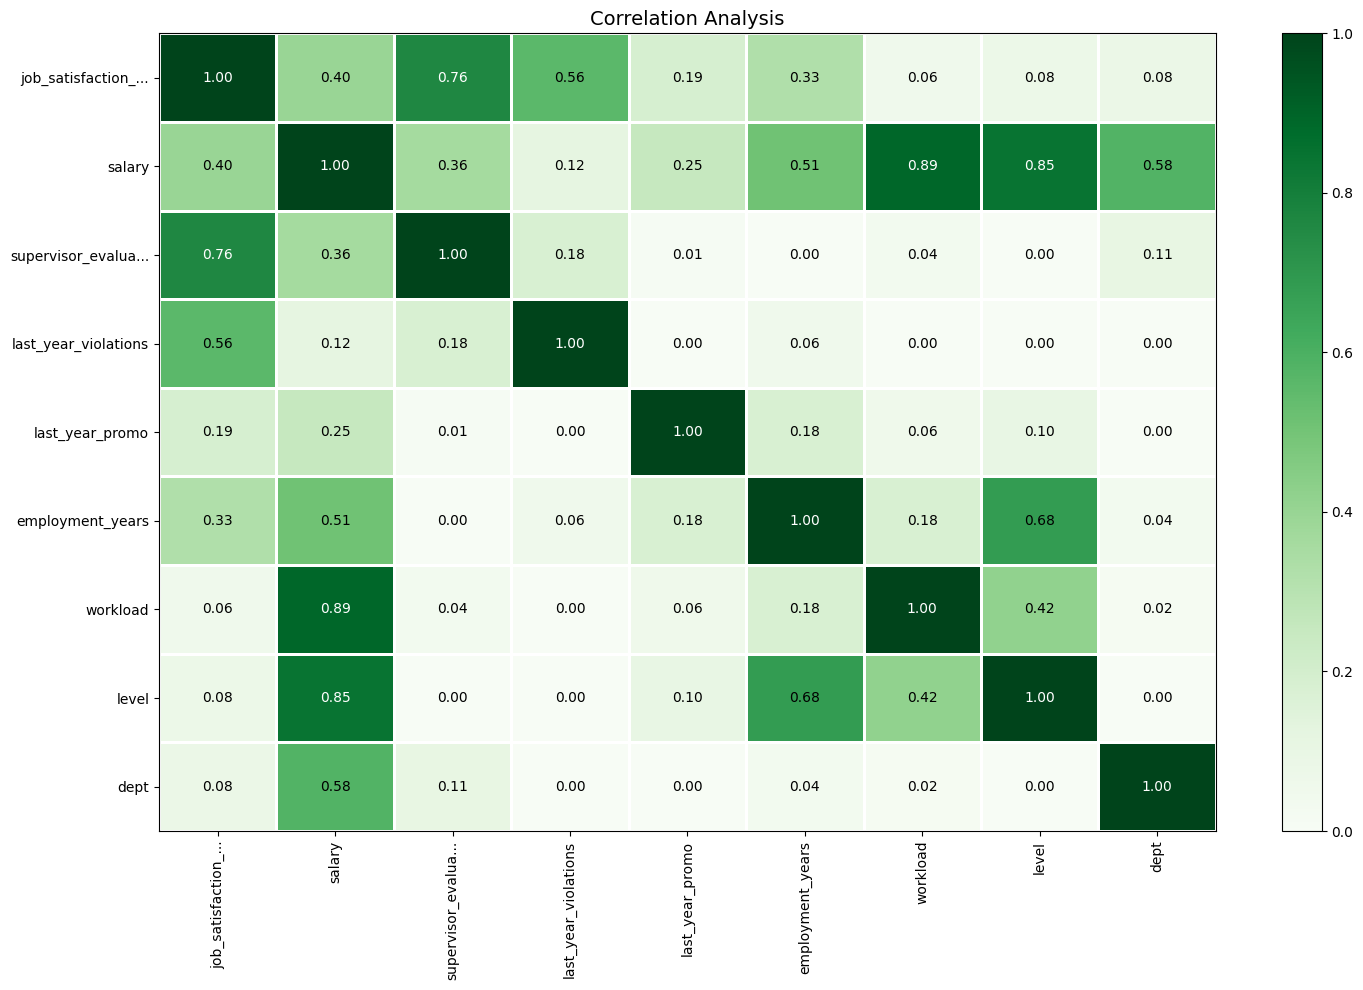

In [19]:
# Create a list with names of quantitative features
interval_cols = ['job_satisfaction_rate']

# Calculate correlations on the training set
phik_overview = phik_matrix(job_X_train.drop('id', axis=1), interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Correlation Analysis',
    fontsize_factor=1,
    figsize=(15, 10),
)

The target feature correlates with several features:

- `last_year_violations` — 0.56. It is quite obvious that receiving notices for employment contract violations negatively affects an employee's satisfaction with their workplace.
- `supervisor_evaluation` — 0.76. The target has the highest correlation with this specific feature.
- There is a strong correlation between `salary` and `workload` (0.79), as well as between `salary` and `level` (0.85). We will not remove features since there are not many of them.

Target leakage was not detected.

Let's look at the types of feature dependencies:

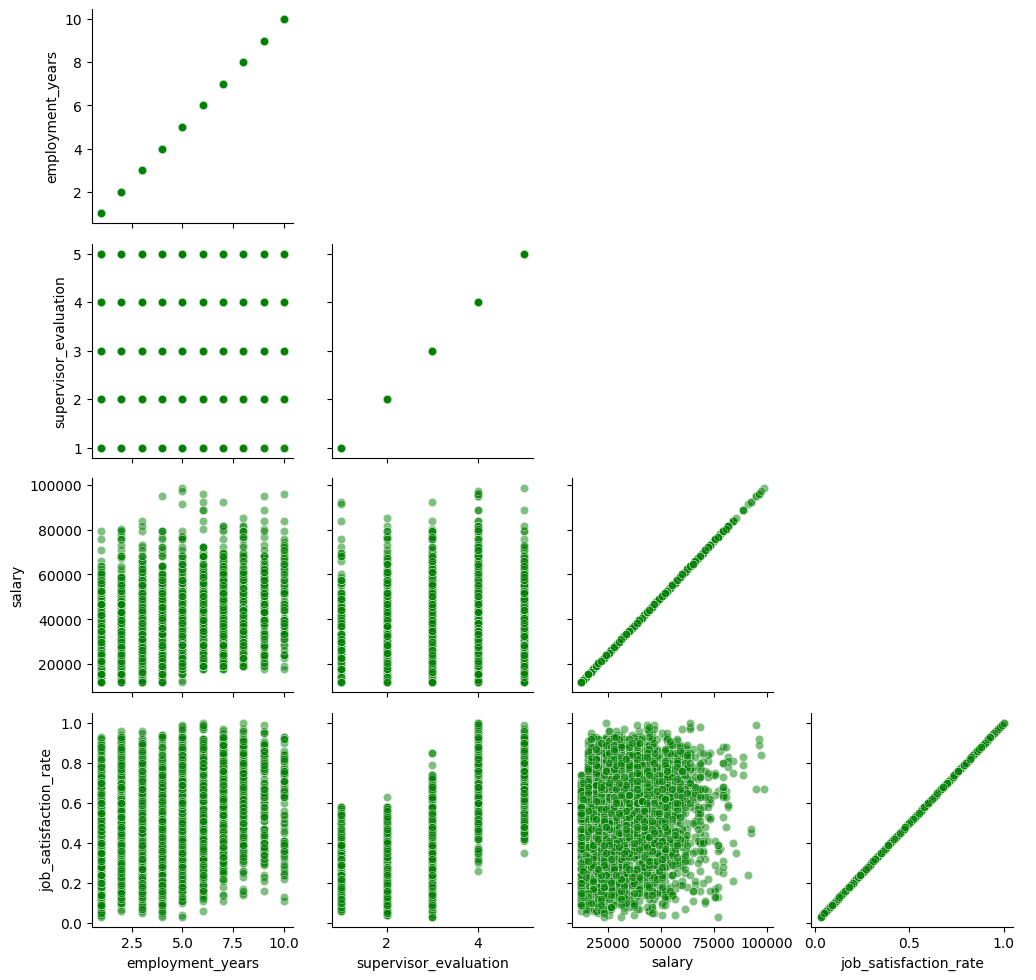

In [20]:
# Plot feature dependency graphs
dependency_type = sns.PairGrid(job_X_train.drop('id', axis=1), diag_sharey=False, corner=True)
dependency_type.map(sns.scatterplot, alpha=0.5, color='green')
dependency_type.add_legend()
plt.show()

- Non-linear dependence of the target `feature job_satisfaction_rate` on features such as `employment_years` and `supervisor_evaluation` is observed in the graphs.
- The relationship between the target and employee salary does not have a distinct shape. This should be taken into account when building the model.

### <a name='Preparation'></a> Data Preparation

In [21]:
# Check dimensions and display the first five records in the table
display(job_X_train.shape)
display(job_X_train.head(5))

(4000, 10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [22]:
# Check dimensions and display the first five records in the table
display(job_X_test.shape)
display(job_X_test.head(5))

(2000, 9)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [23]:
# Check dimensions and display the first five records in the table
display(job_y_test.shape)
display(job_y_test.head(5))

(2000, 2)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


The first five rows of the samples do not match by `id`:

- Index the training set by id, check for duplicates (removing them if necessary), and then separate the target.
- Merge the test features and target first, then index by id, and separate the target again.

In [24]:
# Index the training set by id to simplify access and operations
job_X_train_ml = job_X_train.set_index('id')

# Verification
job_X_train_ml.head(2)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76


In [25]:
# Check the training set for duplicates
job_X_train_ml.duplicated().sum()

np.int64(248)

In [26]:
# Remove duplicates from the training set
job_X_train_ml.drop_duplicates(inplace=True)

# Verification
job_X_train_ml.duplicated().sum()

np.int64(0)

In [27]:
# Extract the target variable from the training set
job_y_train_ml = job_X_train_ml['job_satisfaction_rate']

# Remove the target from the training set, leaving only features
job_X_train_ml = job_X_train_ml.drop('job_satisfaction_rate', axis=1)

# Verification
job_X_train_ml.head(2)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000
653870,hr,junior,high,2,no,no,5,38400


In [28]:
job_y_train_ml.head(2)
# The first rows now match by id.

,job_satisfaction_rate
id,
155278,0.58
653870,0.76


In [29]:
# Merge test features and target
job_test_full = job_X_test.merge(job_y_test, on='id')

# Index the test set by id for consistent operations
job_test_full = job_test_full.set_index('id')

# Re-extract the target variable from the merged test set
job_y_test_ml = job_test_full['job_satisfaction_rate']

# Remove the target from the merged test set, leaving only features
job_X_test_ml = job_test_full.drop('job_satisfaction_rate', axis=1)

# Display the first rows of processed data for verification
display(job_X_test_ml.head(2))  # Test features without target
display(job_y_test_ml.head(2))   # Test target

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000


,job_satisfaction_rate
id,
485046,0.79
686555,0.72


In [30]:
# Check final dimensions after duplicate removal
display(job_X_train_ml.shape)
display(job_X_test_ml.shape)
display(job_y_train_ml.shape)
display(job_y_test_ml.shape)

(3752, 8)

(2000, 8)

(3752,)

(2000,)

#### Pipeline Construction

In [31]:
detailed_df_analysis(job_X_train)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0



Missing values:
                       count  percentage
id                         0         0.0
dept                       0         0.0
level                      0         0.0
workload                   0         0.0
employment_years           0         0.0
last_year_promo            0         0.0
last_year_violations       0         0.0
supervisor_evaluation      0         0.0
salary                     0         0.0
job_satisfaction_rate      0         0.0 

Number of duplicates: 0

Information about categorical features:
dept => 5 unique values
  - sales
  - hr
  - technology
  - purchasing
  - marketing

level => 3 unique values
  - junior
  - middle
  - senior

workload => 3 unique values
  - medium
  - high
  - low

last_year_promo => 2 unique values
  - no
  - yes

last_year_violations => 2 unique values
  - no
  - yes



In [32]:
# Create lists of feature names
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

# Create pipelines for feature preparation
ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

ord_pipe = Pipeline([
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'senior'],
            ['medium', 'high', 'low']
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

# Create a general column transformer for data preparation
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
     ],
    remainder='passthrough')

# Create the final pipeline: data preparation + model
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

### <a name='Training'></a> Model Training

#### Creating the **SMAPE** Metric (Symmetric Mean Absolute Percentage Error)

In [33]:
# Create the custom SMAPE metric
def smape(y_true, y_pred):
    """
    Accepts NumPy arrays or pandas Series and returns the SMAPE value
    (Symmetric Mean Absolute Percentage Error).

    Args:
        y_true (np.array / pandas.Series): Array of actual values.
        y_pred (np.array / pandas.Series): Array of predicted values.
    Returns:
        float: SMAPE value.
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)
    return np.mean(diff) * 100

# Create a custom scorer
smape_score = make_scorer(smape, greater_is_better=False)

#### Hyperparameter grid for multiple models

In [34]:
parameters = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'models': [DecisionTreeRegressor()],
        'models__max_depth': range(1, 21),
        'models__max_features': range(5, 11),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }
]

# Randomized Search for hyperparameter tuning
randomized_search = RandomizedSearchCV(
    pipe_final,
    parameters,
    cv=5,
    scoring=smape_score,
    n_jobs=-1).fit(job_X_train_ml, job_y_train_ml)

print('Best model and its parameters:\n\n', randomized_search.best_estimator_)
print('Best model metric on cross-validation:', randomized_search.best_score_ * -1)

Best model and its parameters:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                             

The best model was a decision tree with a maximum depth of 1 and a maximum number of features used to find the best split in the tree of 9.

Now let's test how the best model performs on the test set and calculate the SMAPE metric.

In [35]:
# Prediction and evaluation on the test set
y_pred_test = randomized_search.best_estimator_.predict(job_X_test_ml)
smape_test = smape(job_y_test_ml, y_pred_test)
print("Test set SMAPE is:", smape_test)

Test set SMAPE is: 14.876994452845013


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


The metric turned out to be 14.9, which is even better than on the training sample, which means our model works well and meets success criterion.

### Feature Analysis

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


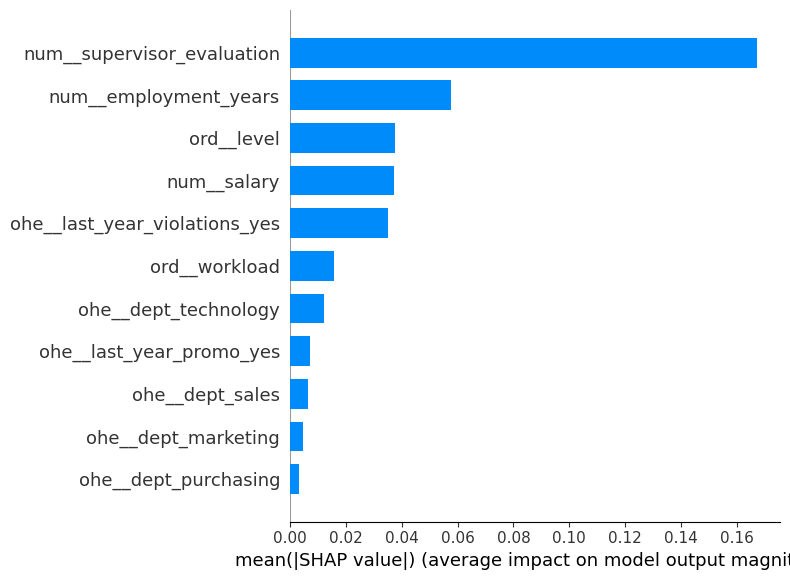

None

In [36]:
# Prepare data for SHAP analysis
model = randomized_search.best_estimator_['models']
preprocessor_pipe = randomized_search.best_estimator_.named_steps['preprocessor']

X_train_scalled = preprocessor_pipe.fit_transform(job_X_train_ml)
X_test_scalled = preprocessor_pipe.transform(job_X_test_ml)
feature_names = randomized_search.best_estimator_[:-1].get_feature_names_out()

# Create Explainer
explainer = shap.TreeExplainer(model)

# Get SHAP values for the data
shap_values = explainer.shap_values(X_test_scalled)

# Visualize feature importance
display(shap.summary_plot(shap_values, X_test_scalled, feature_names=feature_names, plot_type="bar"))

- The `supervisor_evaluation` feature has the greatest impact on the model's predictions, which is consistent with the high importance identified earlier during the correlation analysis.

- `employment_years` ranks second, indicating that an employee's job satisfaction significantly depends on this factor, nearly on par with their position (`level`) and salary level.

**Conclusions for Task 1**:

We have successfully completed the first task: developing a model capable of predicting employee satisfaction levels based on the client's data.

The model training process is complete. Based on the **SMAPE** metric, the Decision Tree was selected as the best model, with a maximum depth of 19 and max_features set to 7.

After testing on the holdout (test) set, the metric showed 14.8, which meet succes ctiterion.

Presumably, the `Decision Tree` outperformed `Linear Regression` due to its greater flexibility and ability to capture non-linear relationships through hyperparameter tuning.

**Additional Step — Baseline Comparison**

To ensure our model provides genuine predictive value, we will compare its performance against a constant model. This will verify if our model is truly better than a simple strategy of predicting the mean value.

Plan:

- Create and "train" a constant model using DummyRegressor.
- Calculate the metric on the test set for this baseline model.
- Compare our model's results with the DummyRegressor results.

In [37]:
# 1. Initialize and train the DummyRegressor (predicting the mean)
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(job_X_train_ml, job_y_train_ml)

# 2. Predict on the test set
y_dummy_pred = dummy_regr.predict(job_X_test_ml)

# 3. Calculate SMAPE for the constant model
smape_dummy = smape(job_y_test_ml, y_dummy_pred)

print(f"Decision Tree SMAPE (Test): {smape_test:.4f}")
print(f"Dummy Regressor SMAPE (Test): {smape_dummy:.4f}")

if smape_test < smape_dummy:
    print("Conclusion: Our model performs better than the constant baseline.")
else:
    print("Conclusion: Our model does not outperform the constant baseline.")

Decision Tree SMAPE (Test): 14.8770
Dummy Regressor SMAPE (Test): 38.2628
Conclusion: Our model performs better than the constant baseline.


## Task 2: Churn Prediction

### <a name='Loading2'></a> Data Loading

In [38]:
# Data loading
quit_X_train = pd.read_csv('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/train_quit.csv')
quit_X_test = pd.read_csv('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/test_features.csv')
quit_y_test = pd.read_csv('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/test_target_quit.csv')

In [39]:
# Let's check the training output
detailed_df_analysis(quit_X_train)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28375,260158.031387,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70150,2.541852,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.00,30000.0,43200.00,96000.0



Missing values:
                       count  percentage
id                         0         0.0
dept                       0         0.0
level                      0         0.0
workload                   0         0.0
employment_years           0         0.0
last_year_promo            0         0.0
last_year_violations       0         0.0
supervisor_evaluation      0         0.0
salary                     0         0.0
quit                       0         0.0 

Number of duplicates: 0

Information about categorical features:
dept => 5 unique values
  - sales
  - purchasing
  - marketing
  - technology
  - hr

level => 3 unique values
  - middle
  - junior
  - sinior

workload => 3 unique values
  - high
  - medium
  - low

last_year_promo => 2 unique values
  - no
  - yes

last_year_violations => 2 unique values
  - no
  - yes

quit => 2 unique values
  - no
  - yes



- No missing values detected in the columns.
- No explicit duplicates found.
- Preliminarily, no anomalous values detected, but outliers are present in the `employment_years` and `salary parameters`, as maximum values differ significantly from the third quartile. These will be examined during the exploratory phase.
- Data types are in order.

In [40]:
# Target
detailed_df_analysis(quit_y_test)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0



Missing values:
      count  percentage
id        0         0.0
quit      0         0.0 

Number of duplicates: 0

Information about categorical features:
quit => 2 unique values
  - yes
  - no



Everything is ok.

In [41]:
detailed_df_analysis(quit_X_test)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0



Missing values:
                       count  percentage
id                         0        0.00
dept                       2        0.10
level                      1        0.05
workload                   0        0.00
employment_years           0        0.00
last_year_promo            0        0.00
last_year_violations       0        0.00
supervisor_evaluation      0        0.00
salary                     0        0.00 

Number of duplicates: 0

Information about categorical features:
dept => 6 unique values
  - marketing
  - hr
  - sales
  - purchasing
  - technology
  - nan
  -  

level => 3 unique values
  - junior
  - middle
  - sinior
  - nan

workload => 4 unique values
  - medium
  - low
  - high
  -  

last_year_promo => 2 unique values
  - no
  - yes

last_year_violations => 2 unique values
  - no
  - yes



- Missing values found in the dept column (as " " and NaN), and in the level and workload columns (as " ").
- No explicit duplicates found.
- Preliminarily, no anomalous values detected, but outliers are present in the `employment_years` and `salary parameters`.
- Data types are in order.

### <a name='Preprocessing2'></a> Data Preprocessing





In [42]:
# Set id as index for the training set
quit_X_train = quit_X_train.set_index('id')

# Merge test feature and target tables
quit_full_test = quit_X_test.merge(quit_y_test, on='id')

# Set id as index for the test set
quit_full_test = quit_full_test.set_index('id')

# Separate the target from the test data again
quit_X_test = quit_full_test.drop('quit', axis=1)
quit_y_test = quit_full_test['quit']

# Verification
display(quit_X_train.head(2))
display(quit_X_test.head(2))
display(quit_y_test.head(2))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000


,quit
id,
485046,no
686555,no


In [43]:
# Correct a spelling error
quit_X_train['level'].replace({'sinior': 'senior'}, inplace=True)

/tmp/ipython-input-1755074936.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  quit_X_train['level'].replace({'sinior': 'senior'}, inplace=True)


We have indexed the samples by `id` to ensure data consistency and ease of joining.

### <a name='Exploratory'></a> Exploratory Data Analysis (EDA)

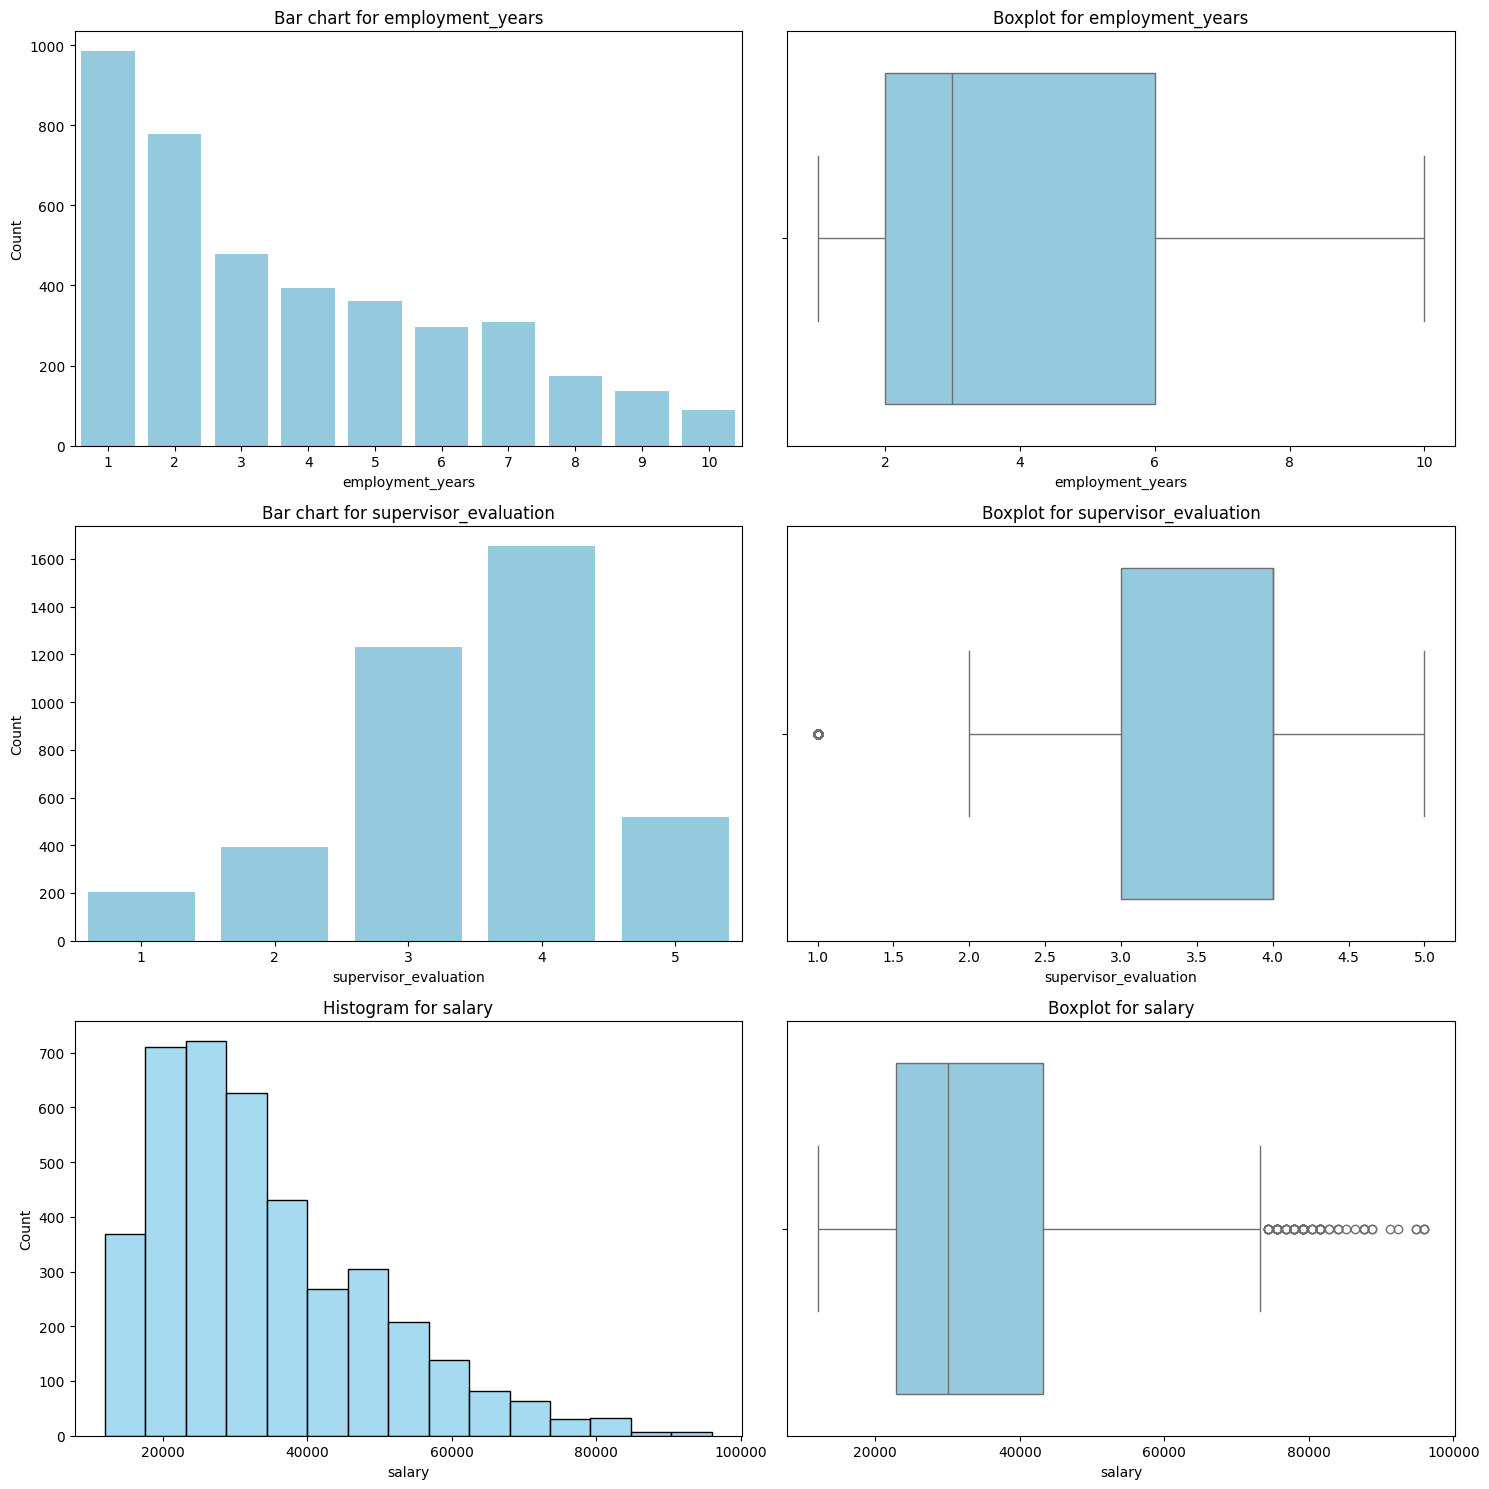

In [44]:
numeric_plot(quit_X_train)

The distributions are almost identical to the exploratory analysis in Task 1.

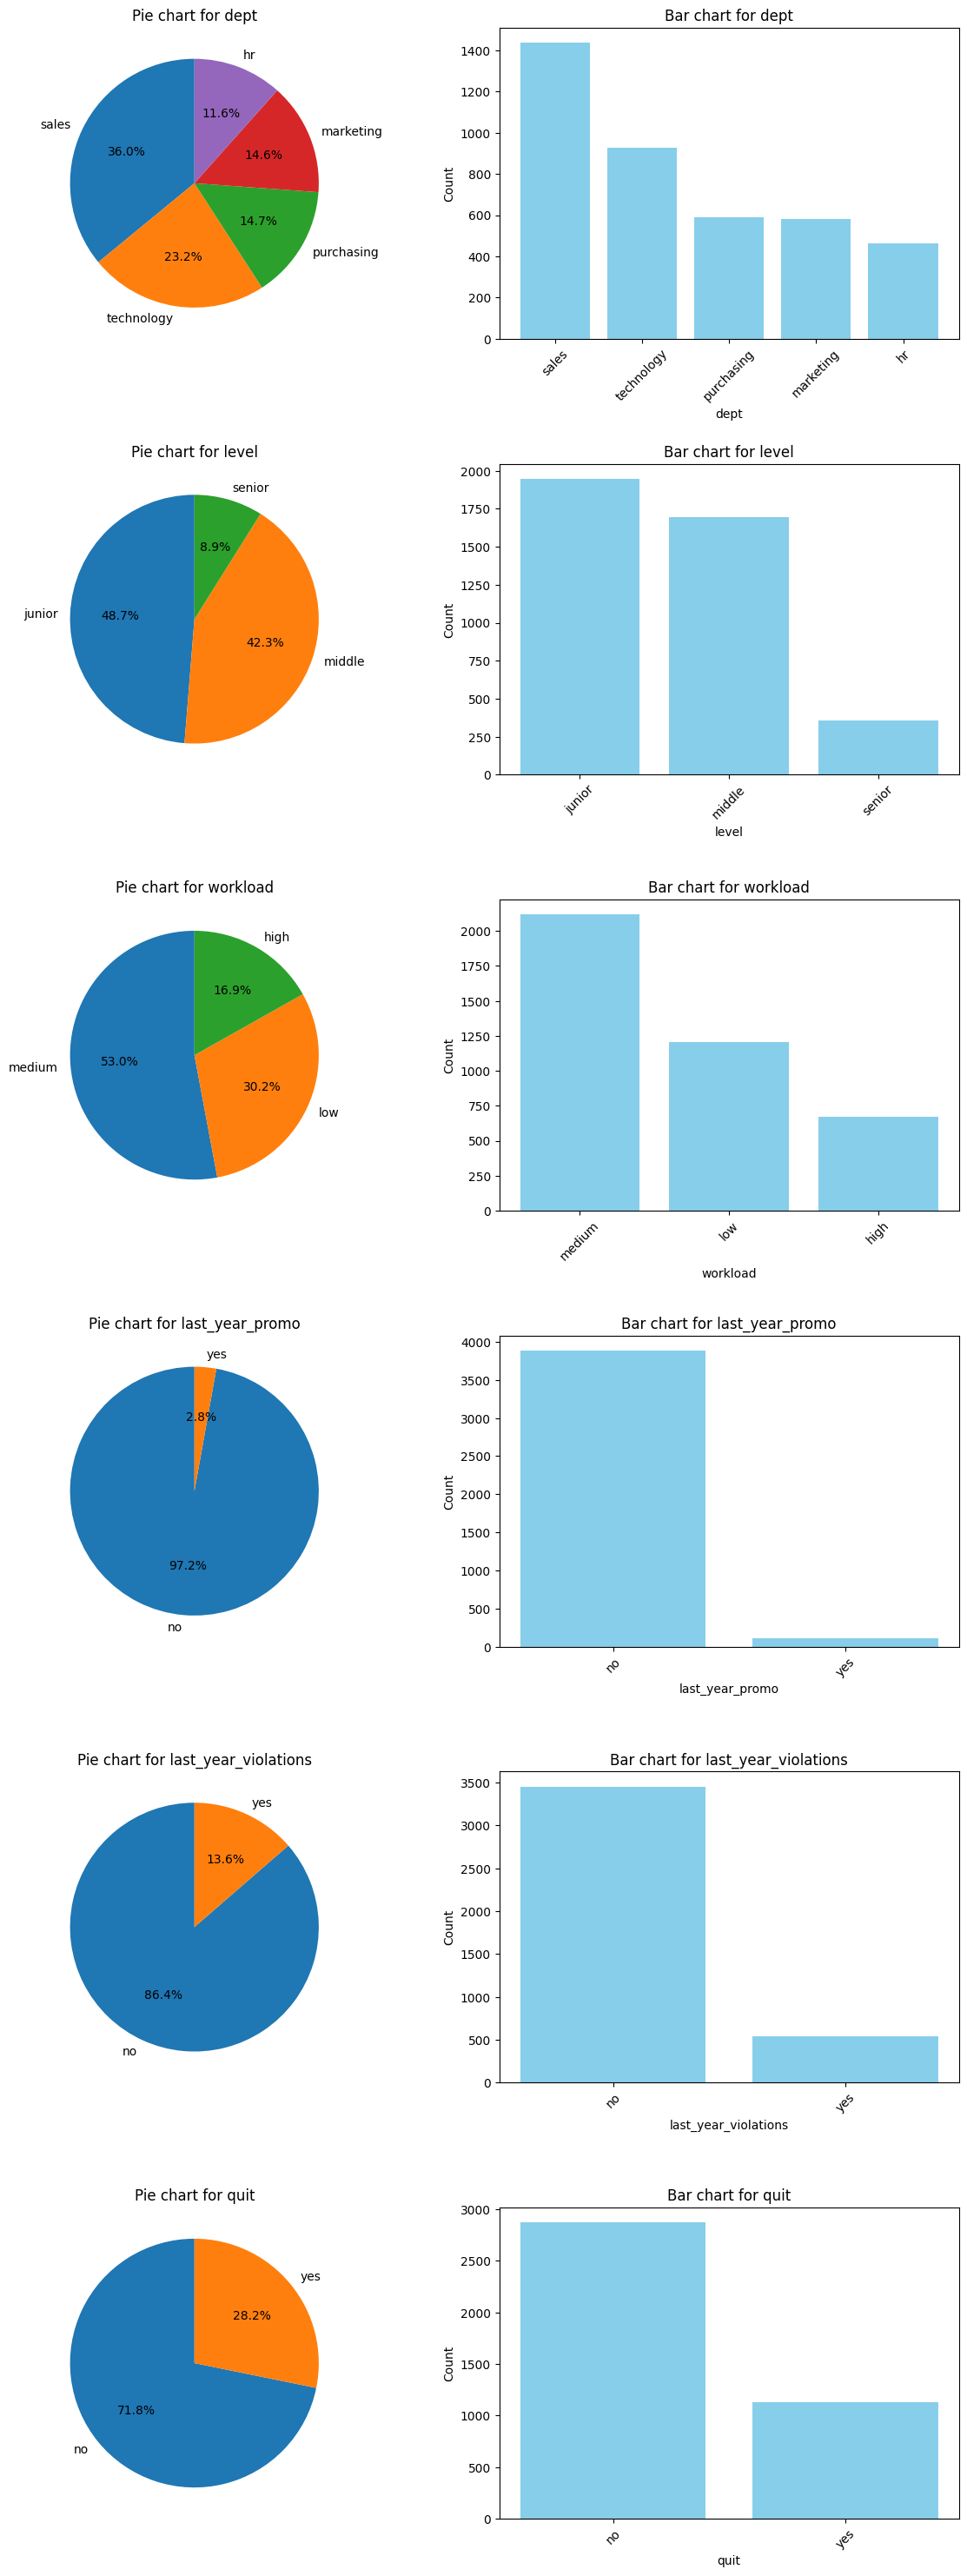

In [45]:
plot_pie_and_bar_charts(quit_X_train)

- The data is almost identical to that in Task 1, with only a few percentage points in the distribution of each parameter, and the overall trends are identical.
- An imbalance in the target feature is visible. This should be taken into account when choosing a metric for the machine learning model.

In [46]:
# Checking the percentage distribution of unique values ​​in quit_y_test
quit_y_test.value_counts(normalize=True) * 100

,proportion
quit,
no,71.8
yes,28.2


The ratio of the quit parameter values ​​in the training and test target samples is identical.

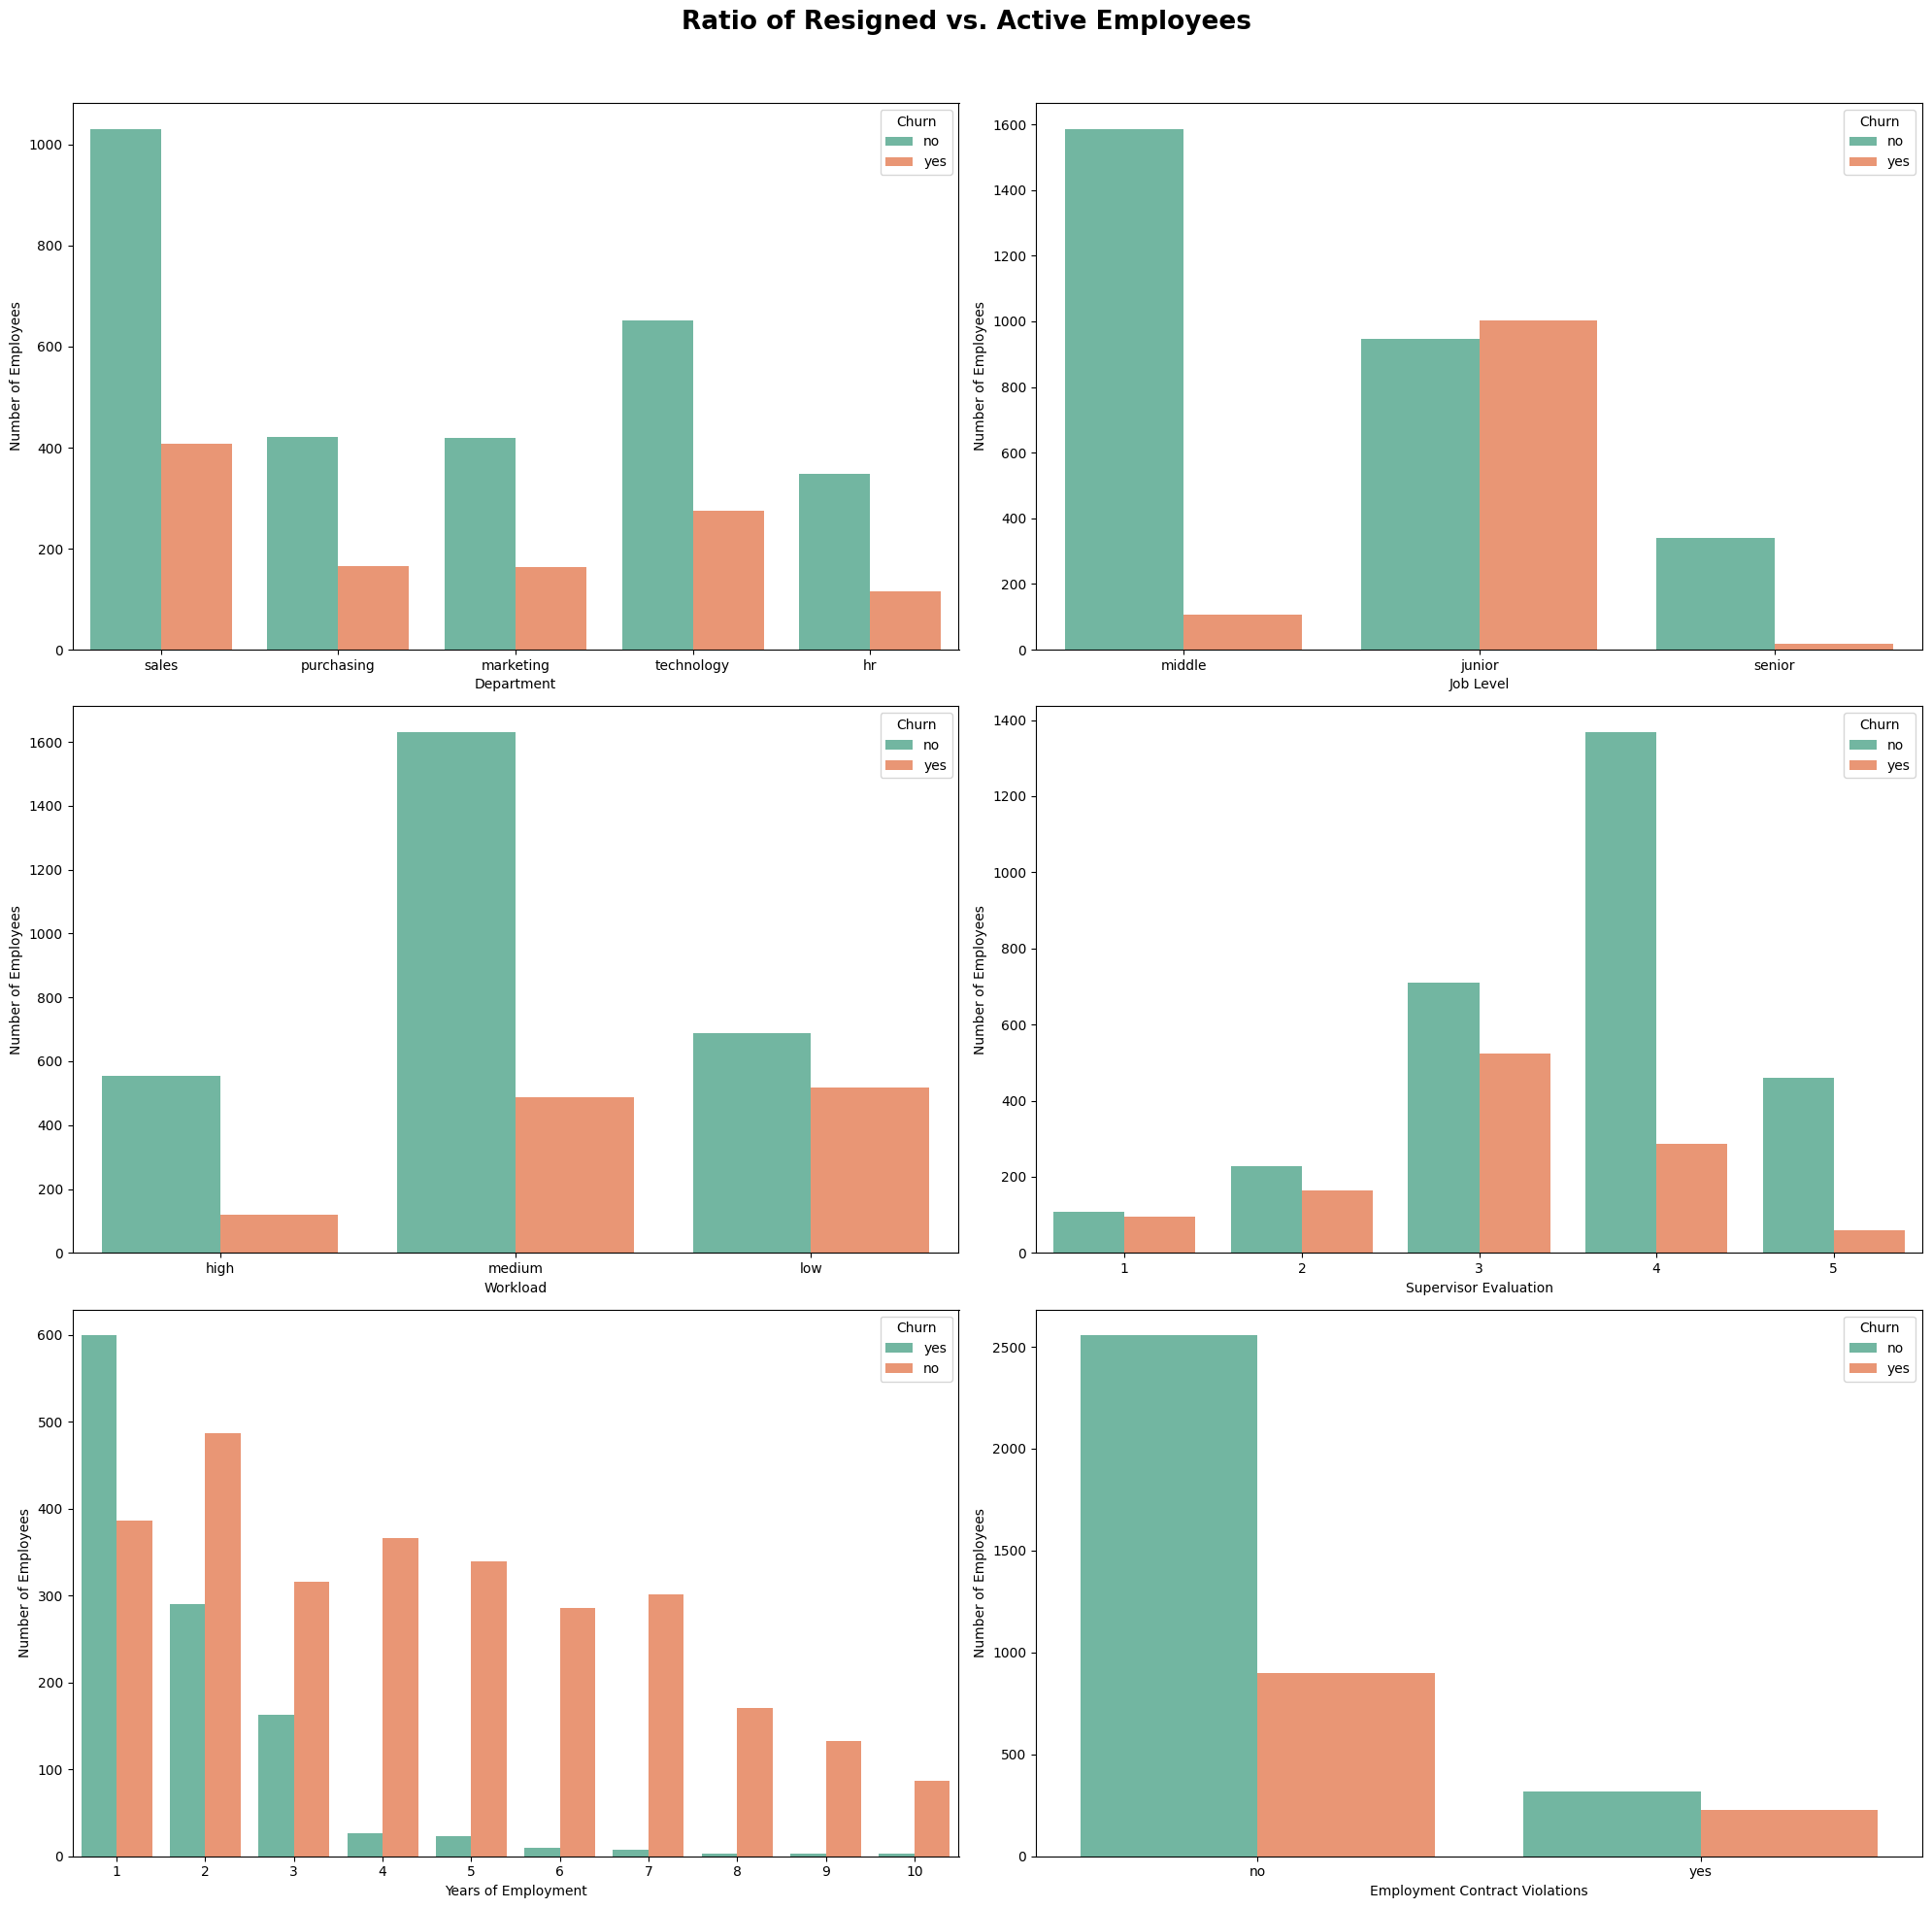

In [47]:
# Data for plotting
columns_info = [
    ('dept', 'Department'),
    ('level', 'Job Level'),
    ('workload', 'Workload'),
    ('supervisor_evaluation', 'Supervisor Evaluation'),
    ('employment_years', 'Years of Employment'),
    ('last_year_violations', 'Employment Contract Violations')
]

# Create plots
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
plt.suptitle('Ratio of Resigned vs. Active Employees', fontsize=19, fontweight='bold')

# Plotting using a loop
for ax, (col, xlabel) in zip(axes.flat, columns_info):
    sns.countplot(x=col, data=quit_X_train, hue='quit', palette="Set2", ax=ax)
    ax.set(xlabel=xlabel, ylabel='Number of Employees')
    ax.legend(title='Churn')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for title display
plt.show()

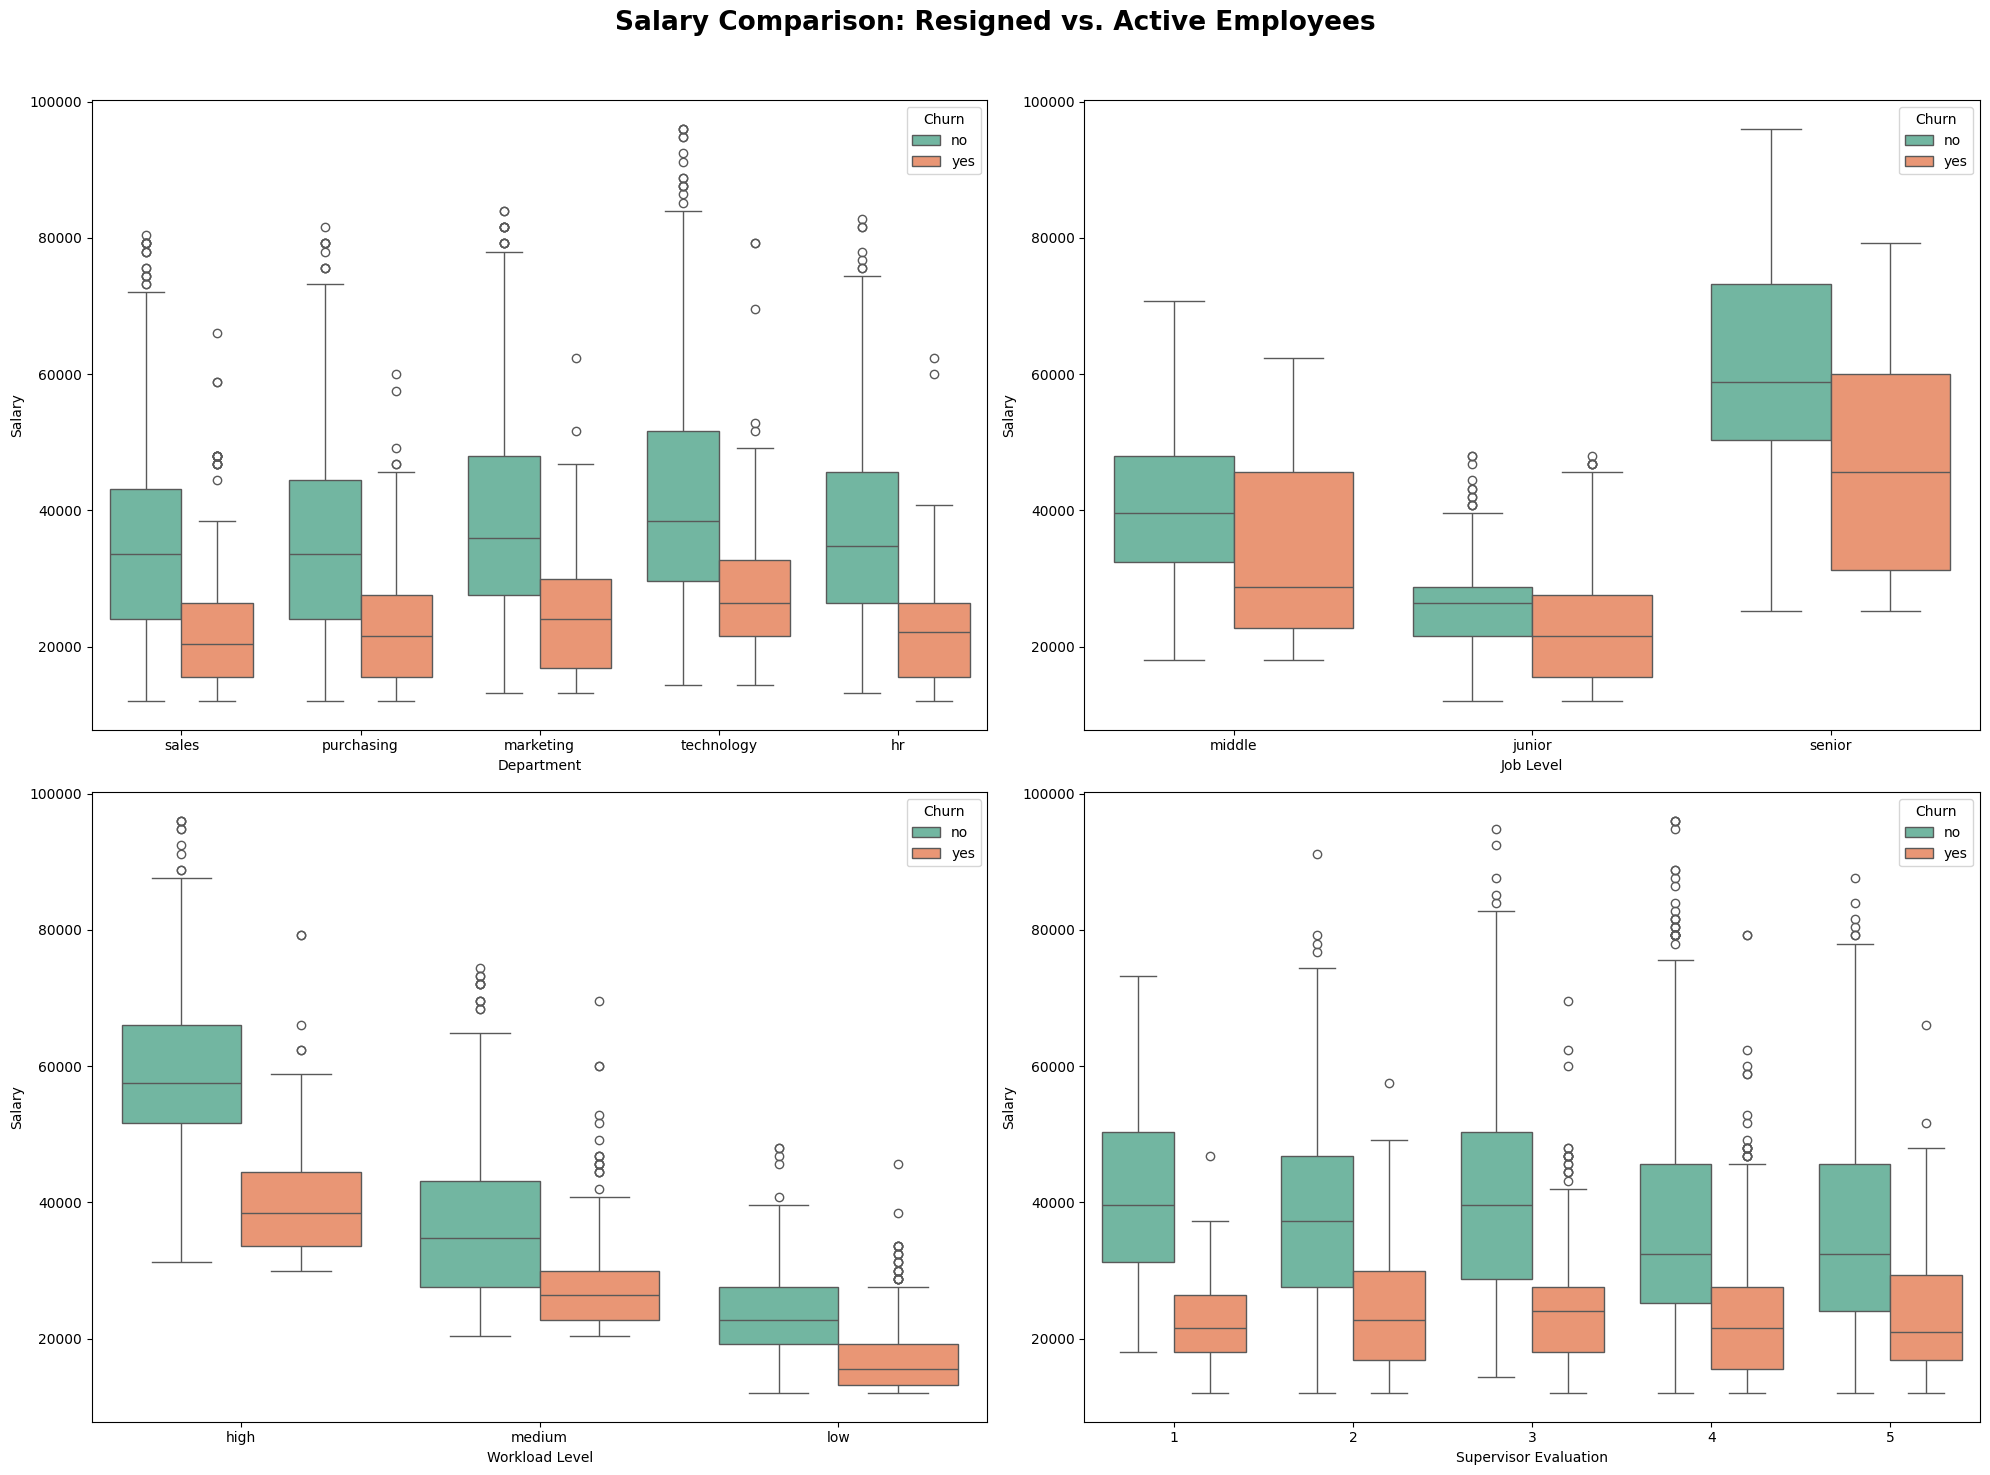

In [48]:
# Data for plotting
columns_info = [
    ('dept', 'Department'),
    ('level', 'Job Level'),
    ('workload', 'Workload Level'),
    ('supervisor_evaluation', 'Supervisor Evaluation')
]

# Create plot grid
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plt.suptitle('Salary Comparison: Resigned vs. Active Employees', fontsize=19, fontweight='bold')

# Plotting in a loop
for ax, (x_col, xlabel) in zip(axes.flat, columns_info):
    sns.boxplot(x=x_col, y='salary', hue='quit',
                palette='Set2', data=quit_X_train, ax=ax)
    ax.set(xlabel=xlabel, ylabel='Salary')
    ax.legend(title='Churn')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Based on the charts, the following conclusions can be drawn:

- Job Level: Employees in junior positions resign most frequently.
- Workload: Those with a low workload are more likely to leave.
- Performance: Churn is higher among employees with lower supervisor evaluations (ranging from 1 to 3).
- Tenure: Employees with shorter tenure (fewer years at the company) exhibit higher churn rates.
- Department: The specific department does not appear to have a significant impact on the probability of resignation.

Furthermore, an analysis of average salaries shows that resigned employees across all categories (departments, workload levels, job levels, and evaluations) earned less on average than those who stayed.

**Typical Churn Profile**: A recently hired junior employee with a low workload, a low supervisor evaluation, and a lower-than-average salary.

#### Correlation analysis

According to analysts, an employee's job satisfaction level can influence their decision to resign. To test this hypothesis, we will add the target feature from the first task (job satisfaction) to the test set for the "Churn" task and calculate the correlation between them.

In [49]:
# Convert Series to DataFrame
quit_y_test_df = quit_y_test.to_frame(name='quit')  # Create DataFrame with column name 'quit'
job_y_test_ml_df = job_y_test_ml.to_frame(name='satisfaction')  # Create DataFrame with column name 'satisfaction'

# Merge data based on the 'id' index
data = quit_y_test_df.merge(job_y_test_ml_df, left_index=True, right_index=True)

# Check the result
data.head()

,quit,satisfaction
id,,
485046,no,0.79
686555,no,0.72
467458,no,0.64
418655,no,0.60
789145,no,0.75


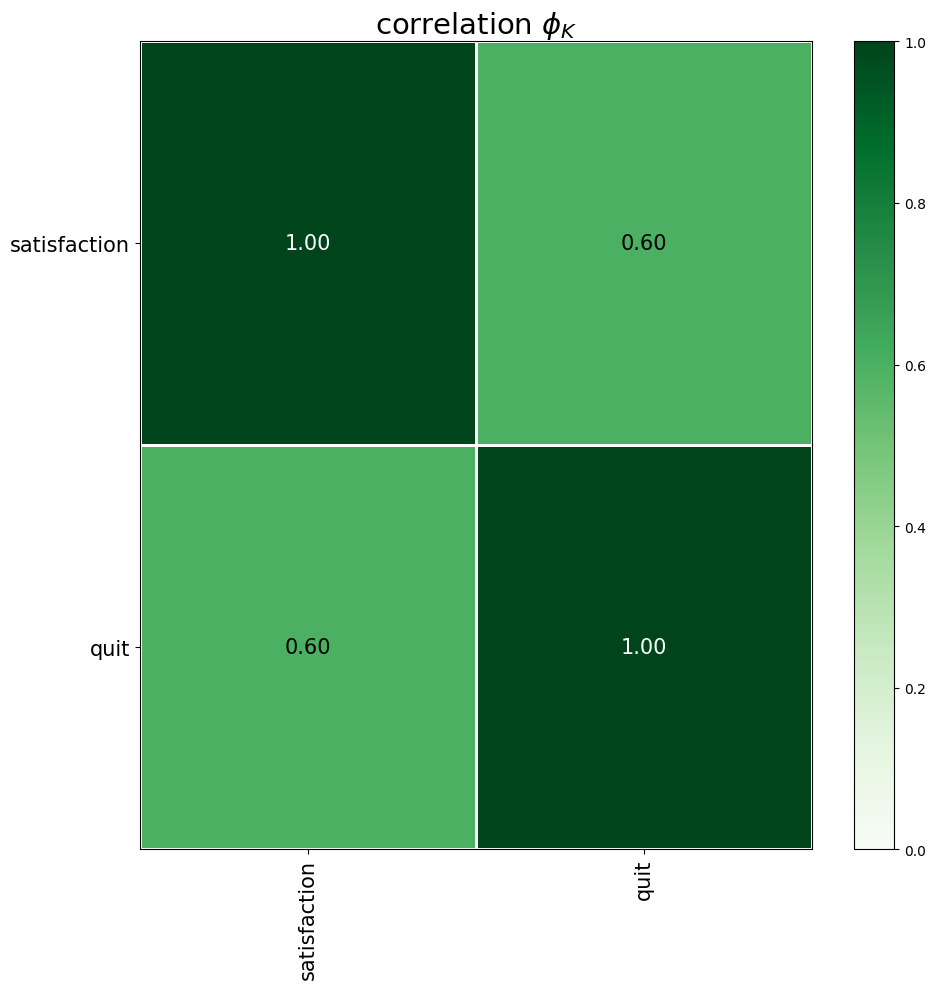

In [50]:
# Specify the list of numerical columns for analysis
# In this case, 'job_satisfaction_rate' represents the job satisfaction level
interval_cols = ['job_satisfaction_rate']

# Calculate the Phik (φ_K) correlation matrix
# Phik is used to analyze correlation between categorical and numerical variables
phik_overview = phik_matrix(data, interval_cols=interval_cols)

# Plot the correlation matrix
plot_correlation_matrix(
    phik_overview.values,            # Correlation matrix values
    x_labels=phik_overview.columns,  # X-axis labels (column names)
    y_labels=phik_overview.index,    # Y-axis labels (row names)
    vmin=0, vmax=1,                  # Range for the color scale
    color_map='Greens',              # Color palette
    title=r'correlation $\phi_K$',   # Plot title
    fontsize_factor=1.5,             # Font size multiplier
    figsize=(10, 10)                 # Plot size
)

The connection is moderately positive, meaning job satisfaction significantly influences the target feature. Therefore, before training the models, we must add this feature to both the training and test sets.

We will now plot heatmaps for visual analysis to see which features influence each class: "Employee Resigned" vs. "Employee Stayed."

Since our numerical parameters `employment_years`, `supervisor_evaluation`, `salary` are discrete, it is better to use Spearman correlation for discrete numerical and ordinal features `level`, `workload`. This method highlights non-linear monotonic relationships.

For categorical non-ordinal features `last_year_promo`, `last_year_violations`, we will use Cramér's V, which evaluates the strength of association between two categorical variables.

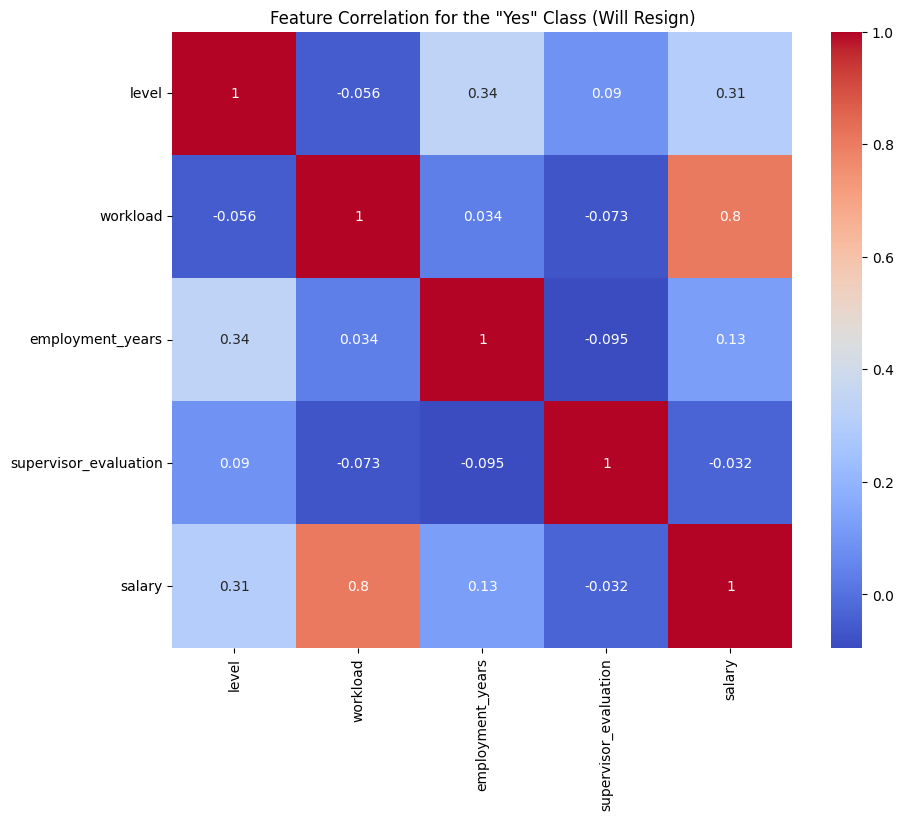

In [51]:
# Create a copy of the table for encoding categorical features
encoded_df = quit_X_train.copy()

# Select columns for OrdinalEncoder (ordinal features)
ord_columns = ['level', 'workload']

# Apply OrdinalEncoder
ord_encoder = OrdinalEncoder(
    categories=[
        ['junior', 'middle', 'senior'],  # Levels
        ['low', 'medium', 'high']        # Workload
    ],
    handle_unknown='use_encoded_value', unknown_value=np.nan)

# Encode ordinal data
encoded_df[ord_columns] = ord_encoder.fit_transform(encoded_df[ord_columns])

# Separate data into "yes" and "no" classes for the target 'quit'
quit_yes = encoded_df[encoded_df['quit'] == 'yes'].drop('quit', axis=1)
quit_no = encoded_df[encoded_df['quit'] == 'no'].drop('quit', axis=1)

# Correlation for the "yes" class
correlation_yes = quit_yes.select_dtypes(include=['number']).corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_yes, annot=True, cmap='coolwarm')
plt.title('Feature Correlation for the "Yes" Class (Will Resign)')
plt.show()

A value of 0.8 between `salary` and `workload` indicates a strong positive monotonic correlation. This means that as one of these features increases, the other tends to increase as well. In the context of the "Yes" class (employees who resigned), this could suggest that employees with high salaries and high workloads are more prone to leaving the company.

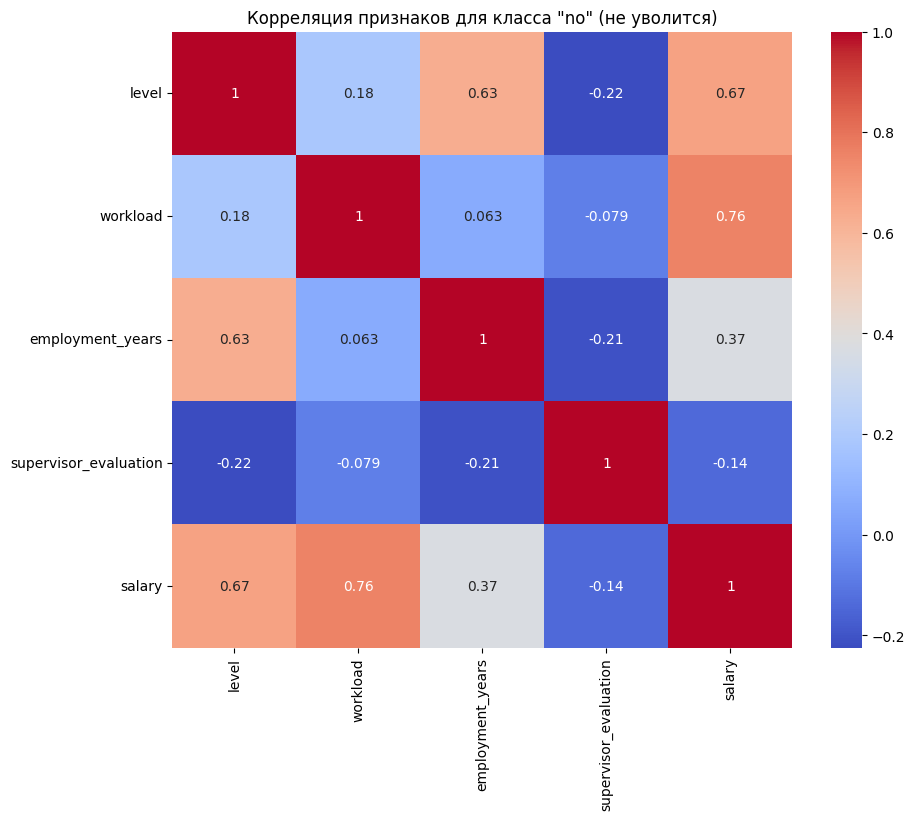

In [52]:
# Корреляция для класса "no"
correlation_no = quit_no.select_dtypes(include=['number']).corr(method='spearman')

# Построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_no, annot=True, cmap='coolwarm')
plt.title('Корреляция признаков для класса "no" (не уволится)')
plt.show()

- `employment_years` and `level` (0.66): This correlation coefficient indicates that tenure is directly related to career progression. The longer an employee stays with the company, the higher their professional level typically becomes. This reflects the standard career path of employees who choose to remain with the organization.
- Workload Dynamics: Workload increases alongside salary, and the employee's level rises as they accumulate more experience.
- `salary` and `level`: The correlation here confirms that as an employee advances through professional levels (e.g., from Junior to Middle or Senior), their salary typically grows. This upward financial trajectory likely serves as a key retention factor, discouraging employees from resigning.

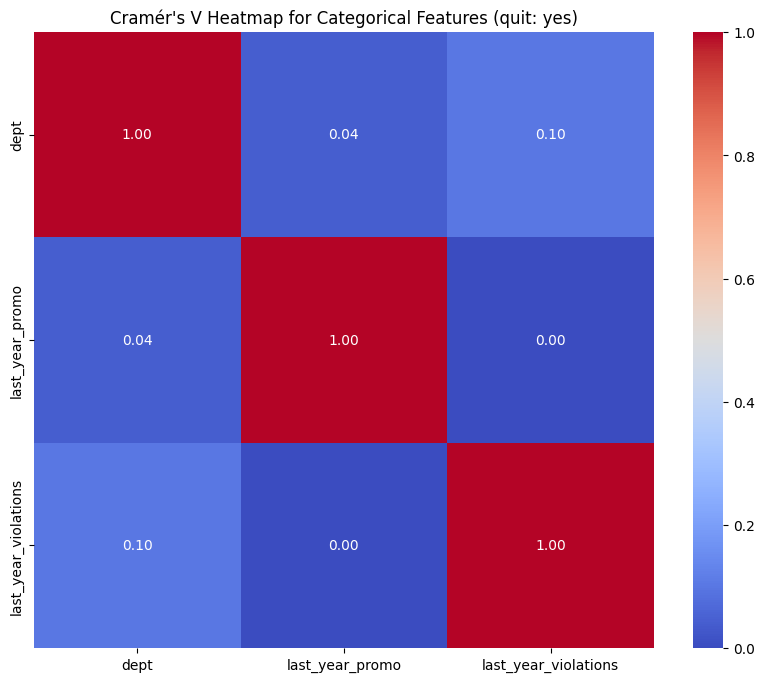

In [53]:
def cramers_v(confusion_matrix):
    """Calculate the Cramér's V coefficient."""
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Example: Prepare categorical features
categorical_columns = ['dept', 'last_year_promo', 'last_year_violations']

# Split data into classes
quit_yes_cat = encoded_df[encoded_df['quit'] == 'yes'][categorical_columns]

# Create Cramér's V matrix
cramers_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Fill Cramér's V matrix
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            cramers_matrix.loc[col1, col2] = 1.0  # Self-correlation
        else:
            confusion_matrix_yes = pd.crosstab(quit_yes_cat[col1], quit_yes_cat[col2])
            cramers_matrix.loc[col1, col2] = cramers_v(confusion_matrix_yes.values)

# Convert to numeric format
cramers_matrix = cramers_matrix.astype(float)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Cramér's V Heatmap for Categorical Features (quit: yes)")
plt.show()

There are no strong associations here.

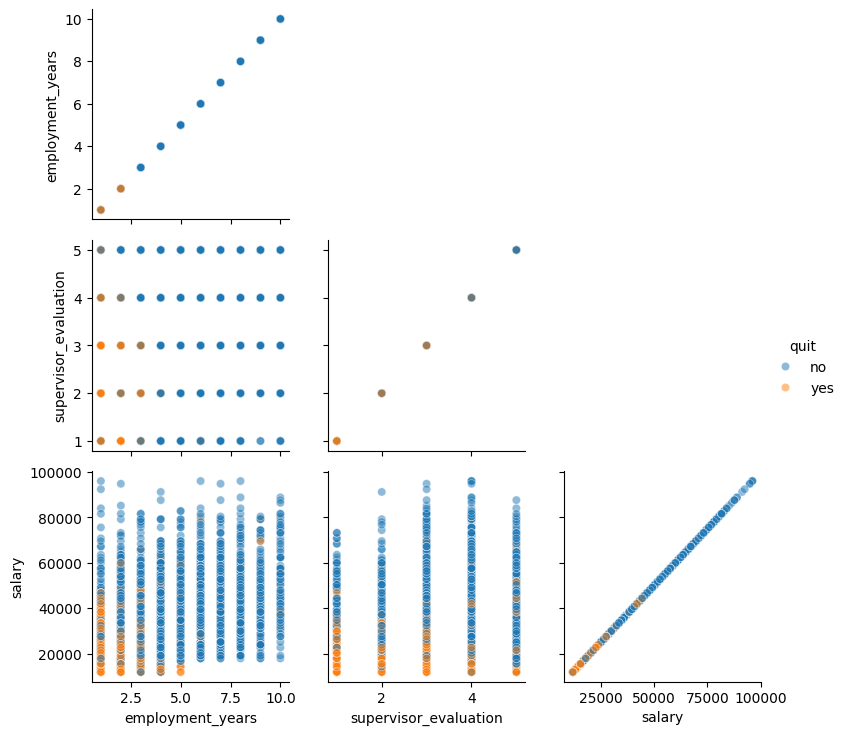

In [54]:
# Plot feature dependency graphs
dependency = sns.PairGrid(quit_X_train, diag_sharey=False, corner=True, hue='quit')
dependency.map(sns.scatterplot, alpha=0.5)
dependency.add_legend()
plt.show()

### <a name='Engineering2'></a> Feature Engineering

Adding a New Feature We will add the job satisfaction level as a feature to both the training and test sets. To do this, we use the best model from the first task to generate satisfaction level predictions. These predictions will then be added as a new column to each dataset.

In [55]:
# Add predicted job satisfaction levels to quit_X_test
# Using the model obtained during training to predict satisfaction levels on job_X_test_ml
quit_X_test['job_satisfaction_rate_pred'] = y_pred_test

# Verification
quit_X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.885000
686555,hr,junior,medium,1,no,no,4,30000,0.678750
467458,sales,middle,low,5,no,no,4,19200,0.643333
418655,sales,middle,low,6,no,no,4,19200,0.655000
789145,hr,middle,medium,5,no,no,5,40800,0.830000


In [56]:
# Add predicted job satisfaction levels to quit_X_train
quit_X_train['job_satisfaction_rate_pred'] = randomized_search.best_estimator_.predict(quit_X_train)

# Verification
quit_X_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.640000
814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.430000
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.335000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.825185


The data is now ready for the final preparation stage before model training.

### <a name='Preparation2'></a> Data Preparation

In [57]:
# Check data for missing values and duplicates
detailed_df_analysis(quit_X_train)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.640000
814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.430000
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.335000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.825185



<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 723290 to 853842
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   dept                        4000 non-null   object 
 1   level                       4000 non-null   object 
 2   workload                    4000 non-null   object 
 3   employment_years            4000 non-null   int64  
 4   last_year_promo             4000 non-null   object 
 5   last_year_violations        4000 non-null   object 
 6   supervisor_evaluation       4000 non-null   int64  
 7   salary                      4000 non-null   int64  
 8   quit                        4000 non-null   object 
 9   job_satisfaction_rate_pred  4000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 343.8+ KB


None

,count,mean,std,min,25%,50%,75%,max
employment_years,4000.0,3.701500,2.541852,1.00,2.000,3.000000,6.00000,10.000000
supervisor_evaluation,4000.0,3.474750,1.004049,1.00,3.000,4.000000,4.00000,5.000000
salary,4000.0,33805.800000,15152.415163,12000.00,22800.000,30000.000000,43200.00000,96000.000000
job_satisfaction_rate_pred,4000.0,0.538962,0.217428,0.05,0.355,0.543333,0.69375,0.986667



Missing values:
                            count  percentage
dept                            0         0.0
level                           0         0.0
workload                        0         0.0
employment_years                0         0.0
last_year_promo                 0         0.0
last_year_violations            0         0.0
supervisor_evaluation           0         0.0
salary                          0         0.0
quit                            0         0.0
job_satisfaction_rate_pred      0         0.0 

Number of duplicates: 1413

Information about categorical features:
dept => 5 unique values
  - sales
  - purchasing
  - marketing
  - technology
  - hr

level => 3 unique values
  - middle
  - junior
  - senior

workload => 3 unique values
  - high
  - medium
  - low

last_year_promo => 2 unique values
  - no
  - yes

last_year_violations => 2 unique values
  - no
  - yes

quit => 2 unique values
  - no
  - yes



In [58]:
# Remove duplicates
quit_X_train = quit_X_train.drop_duplicates()

# Verification
quit_X_train.duplicated().sum()

np.int64(0)

In [59]:
# Extract target from training data
quit_y_train = quit_X_train['quit']

# Remove target from training features
quit_X_train = quit_X_train.drop('quit', axis=1)

In [60]:
# Encode the target variable using LabelEncoder
le = LabelEncoder()

# Apply fit_transform to the training target
quit_y_train = le.fit_transform(quit_y_train)

# Apply transform to the test target
quit_y_test = le.transform(quit_y_test)

In [61]:
display(quit_X_train.shape)
display(quit_y_train.shape)
display(quit_X_test.shape)
display(quit_y_test.shape)

(2587, 9)

(2587,)

(2000, 9)

(2000,)

#### Pipeline Construction

In [62]:
# Create lists with feature names
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_pred']

# Create pipelines for feature preparation
ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

ord_pipe = Pipeline([
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'senior'],
            ['medium', 'high', 'low']
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

# Create a general data preprocessing pipeline
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
     ],
    remainder='passthrough')

# Update the model in the final pipeline
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

### <a name='Training2'></a> Model Training

#### Hyperparameter Tuning for Multiple Models

We will run the training process using `RandomizedSearchCV` to save computational resources and speed up the algorithm. To evaluate model quality, we will use the **ROC-AUC** metric, as it is a versatile and balanced metric that is independent of the classification threshold.

In [63]:
param_grid_2 = [
    # Decision Tree Classifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 21),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # K-Neighbors Classifier
    {
        'models': [KNeighborsClassifier(n_jobs=-1, weights='distance')],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },
    # Logistic Regression
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            class_weight='balanced',
            solver='liblinear',
        )],
        'models__penalty': ['l1', 'l2'],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    }
]

# Run RandomizedSearch
randomized_search = RandomizedSearchCV(
    pipe_final_2,
    param_grid_2,
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1).fit(quit_X_train, quit_y_train)

print('Best model and its parameters:\n\n', randomized_search.best_estimator_)
print('Best model metric on cross-validation:', randomized_search.best_score_)

Best model and its parameters:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                             

In [64]:
y_test_proba = randomized_search.predict_proba(quit_X_test)[:,1]
print(f'ROC-AUC metric on the test set: {roc_auc_score(quit_y_test, y_test_proba)}')

ROC-AUC metric on the test set: 0.9115784092929532


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


The success criterion established for this task is **ROC-AUC 0.91** on the test set. Our model achieved a result of 0.91. This performance is nearly identical to the result obtained on the training set, indicating that the model generalizes well and does not suffer from significant overfitting. The success criterion has been met.

### Feature Analysis

To understand the model's decision-making process, we will analyze feature importance using the SHAP (SHapley Additive exPlanations) module.

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


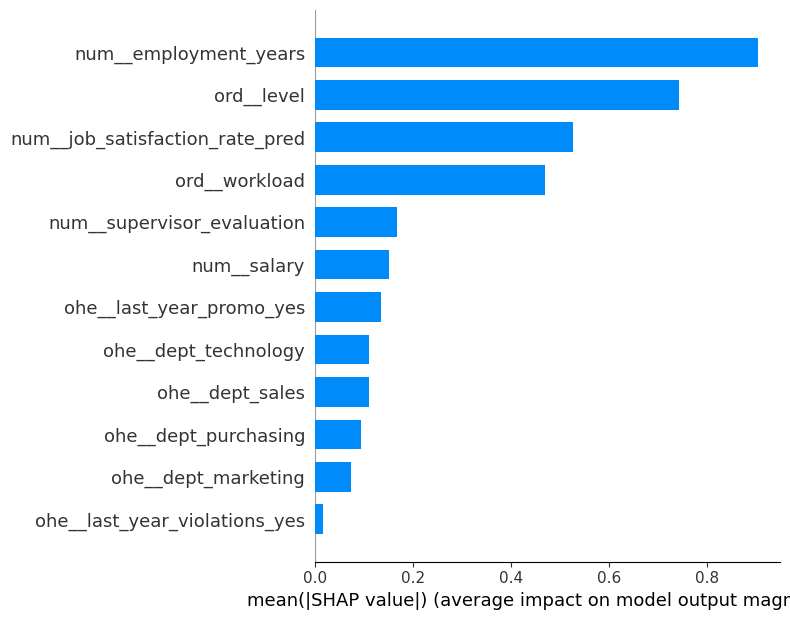

None

In [65]:
# Prepare data for SHAP analysis
model = randomized_search.best_estimator_['models']
preprocessor_pipe = randomized_search.best_estimator_.named_steps['preprocessor']

# Transform datasets using the preprocessor from the best pipeline
X_train_scaled = preprocessor_pipe.fit_transform(quit_X_train)
X_test_scaled = preprocessor_pipe.transform(quit_X_test)

# Extract feature names after preprocessing
feature_names = randomized_search.best_estimator_[:-1].get_feature_names_out()

# Create Explainer (LinearExplainer is used as the best model was Logistic Regression)
explainer = shap.LinearExplainer(model, X_train_scaled)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test_scaled)

# Visualize feature importance
display(shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, plot_type="bar"))

Мы видим, что для нашей модели наиболее важным оказался признак `level` и `employment_years`, а вот признаки с нарушением трудового договора (`last_year_violations`) и отделом (`dept`) похоже мало влияют на нашу модель.

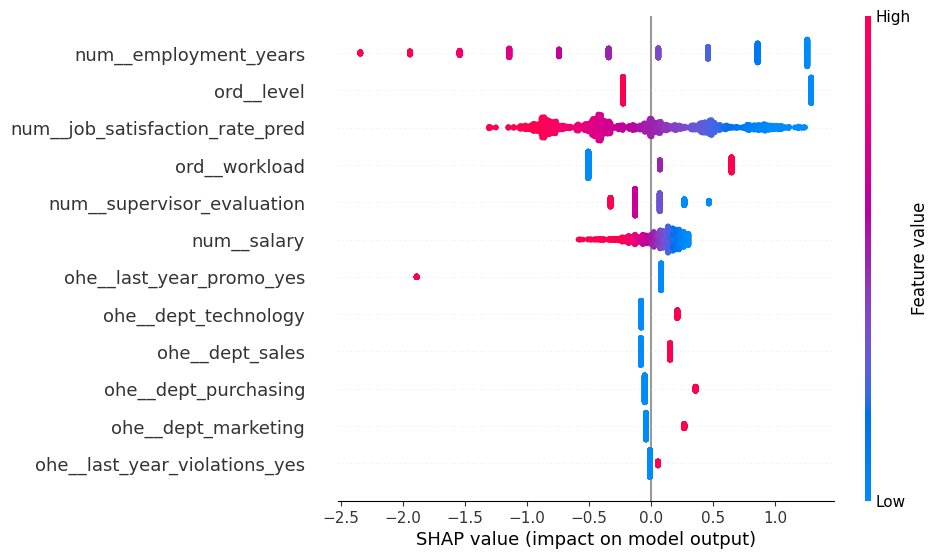

In [66]:
# Convert shap_values into an Explanation object
shap_values_explanation = shap.Explanation(values=shap_values,
                                           base_values=explainer.expected_value,
                                           data=X_test_scaled,
                                           feature_names=feature_names)

# Visualize feature importance using a beeswarm plot
shap.plots.beeswarm(shap_values_explanation, max_display=16)

The probability of employee churn increases with:
- Lower tenure (fewer years of employment).
- Lower job level.
- Lower job satisfaction rates.
- Lower salaries.
- Lower supervisor evaluations.

**Conclusion of Task 2**:
- We tuned the hyperparameters of three models within a pipeline using RandomizedSearchCV: LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier.

**Results:**
- **Best Model**: LogisticRegression(C=6, class_weight='balanced', random_state=42, solver='liblinear')
- **Test ROC-AUC**: ~ 0.91, which rounds to the success criterion of **0.91**
- **Key Drivers**: The employment_years and level features exert the most significant influence on the model’s decisions. These two indicators are the primary factors in an employee's decision to resign.

## General Conclusion

1. **Initial Data and Preprocessing**

- Task 1: Data was integrated from multiple sources. We handled missing values in dept and level using a SimpleImputer pipeline and corrected a recurring spelling error (sinior to senior). Tables were indexed by id.
- Task 2: Data remained consistent across training and test sets. A recurring spelling error was corrected  (sinior to senior). Targets were encoded using LabelEncoder.

2. **Exploratory Data Analysis (EDA)**

- Task 1: Identified that the workforce is skewed towards those with under 3 years of experience. We found that while "Sales" is the largest department, "Purchasing" has the highest satisfaction.
- Task 2: Churn is most prevalent among Junior employees with low workloads and low performance ratings.
- Visual Heatmap Analysis:
   - Churners: Strong correlation (0.8) between `salary` and `workload`, suggesting high-pressure/high-pay roles may trigger burnout/resignation.
   - Non-Churners: A healthy correlation (0.66) between `employment_years` and `level` confirms that staying leads to career growth.

3. **Correlation Analysis**

- Task 1: Target satisfaction is highly correlated with `supervisor_evaluation` (0.76) and `last_year_violations` (0.56).
- Task 2: Job satisfaction showed a moderate positive correlation with churn, confirming it as a vital predictor.

4. **Model Selection and Performance**

- Task 1: The DecisionTreeRegressor was the winner, achieving a **SMAPE ~ 14.9** on test set.
- Task 2: Logistic Regression was selected due to its performance with imbalanced classes, reaching a **ROC-AUC 0.91** on test set.

5. **SHAP Feature Importance**
- Task 1: Supervisor evaluations and tenure are the primary predictors of satisfaction.
- Task 2: Position level and tenure are the strongest predictors of churn; departmental or disciplinary factors have minimal impact.

## Business Recommendations

- Performance Feedback: Focus on the quality of labor assessment. Regular, constructive feedback from supervisors is a proven driver of job satisfaction.
- Retention Strategies: Churn is highest in the first 2 years. Implement "New Joiner" support programs, including social events, bonuses, and clear career mapping for the 1–2 year mark.
- Sales Department Optimization: Review salary structures and working conditions in the Sales department. Introducing flexible or remote work options could help stabilize this high-churn area.
- Work Environment: Since satisfaction is the "heart" of the churn problem, creating an environment where employees find meaning and enjoyment in their tasks is critical.

Key Action Items:
- Support employees with lower experience (0–2 years) through mentorship.
- Develop retention programs that improve working conditions alongside career growth.
- Launch management training programs to help supervisors better motivate teams at all levels.